<a href="https://colab.research.google.com/github/Vamsi-Malineni/Research-work/blob/master/adaptive_with_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import scipy.io
import time
import pandas as pd
import math
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import copy

In [ ]:
# set random seed
np.random.seed(1234)
tf.set_random_seed(1234)


class pinn:
    # Initialize the class
    def __init__(self, data_idx, data_t0, data_sup_b_train, layers, N_train, batch_size,load = False, file=None):
        
#============================================================================================================================#
#=============================================Loading data ==================================================================#
#============================================================================================================================#
        self.data_t0 = data_t0
        self.data_sup_b_train = data_sup_b_train
        self.data_idx = data_idx
        self.N_train = N_train
        self.batch_size=batch_size

        self.lowb = data_idx.min(0)  
        self.upb = data_idx.max(0)

        self.layers = layers

#============================================================================================================================#
#=======================================Loading / Initializing NN============================================================#
#============================================================================================================================#
        if load==True:
            # collecting weights and biases from the pickle file
            self.weights,self.biases,self.ewanb,ac_bc,ac_ic=self.load_parameters_encoder(file,self.layers)
            
            # loading encoder weights and biases from pickle file
            self.encoder_weights_1=self.ewandb[0]
            self.encoder_biases_1=self.ewandb[2]

            self.encoder_weights_2=self.ewandb[1]
            self.encoder_biases_2=self.ewandb[3]
            
            # The adaptive constants are added here so as to start training from a check point
            self.beta=0.9
            self.adaptive_constant_bcs_val=ac_bc
            self.adaptive_constant_ics_val=ac_ic

        if load ==False:
            # Initializing weights and biases for model using xavier initialization method.
            self.weights, self.biases = self.initialize_NN(layers)
            
            # Initializing weights and biases for encoder using xavier initialization method
            self.encoder_weights_1=self.xavier_init([3,self.layers[1]])
            self.encoder_biases_1=self.xavier_init([1,self.layers[1]])

            self.encoder_weights_2=self.xavier_init([3,self.layers[1]])
            self.encoder_biases_2=self.xavier_init([1,self.layers[1]])
            
            # Adaptive weighting constants initialized to 1.
            self.beta=0.9
            self.adaptive_constant_bcs_val=np.array(1.0)  # arw for boundary conditions
            self.adaptive_constant_ics_val=np.array(1.0)  # arw for initial conditions

#============================================================================================================================#
#=============================================Specifying Placeholders========================================================#
#============================================================================================================================#

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        # learning rate placeholder
        self.learning_rate = tf.placeholder(tf.float32, shape=[])
        
        # initial condition placeholders
        self.x_ini_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.y_ini_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_ini_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.u_ini_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.v_ini_tf = tf.placeholder(tf.float32, shape=[None, 1])

        # boundary condition placeholders
        self.x_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.U_bc1_tf = tf.placeholder(tf.float32, shape=(None, 2))

        self.x_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.U_bc2_tf = tf.placeholder(tf.float32, shape=(None, 2))

        self.x_bc3_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc3_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_bc3_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.U_bc3_tf = tf.placeholder(tf.float32, shape=(None, 2))

        self.x_bc4_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc4_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_bc4_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.U_bc4_tf = tf.placeholder(tf.float32, shape=(None, 2))

        # domain residual placeholders
        self.x_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.y_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, 1])

        # defining a placeholder for adaptive constant
        self.adaptive_constant_bcs_tf=tf.placeholder(tf.float32,shape=self.adaptive_constant_bcs_val.shape)
        self.adaptive_constant_ics_tf=tf.placeholder(tf.float32,shape=self.adaptive_constant_ics_val.shape)
        
#============================================================================================================================#
#=============================================Evaluating Predictions=========================================================#
#============================================================================================================================#

        # Initial value predictions
        self.u_ini_pred, self.v_ini_pred, self.p_ini_pred = self.net_NS(self.x_ini_tf, self.y_ini_tf, self.t_ini_tf)
        
        # Boundary value predictions

        self.u_bc1_pred, self.v_bc1_pred,_ = self.net_NS(self.x_bc1_tf, self.y_bc1_tf,self.t_bc1_tf)
        self.u_bc2_pred, self.v_bc2_pred,_ = self.net_NS(self.x_bc2_tf, self.y_bc2_tf,self.t_bc2_tf)
        self.u_bc3_pred, self.v_bc3_pred,_ = self.net_NS(self.x_bc3_tf, self.y_bc3_tf,self.t_bc3_tf)
        self.u_bc4_pred, self.v_bc4_pred,_ = self.net_NS(self.x_bc4_tf, self.y_bc4_tf,self.t_bc4_tf)
        
        self.U_bc1_pred = tf.concat([self.u_bc1_pred, self.v_bc1_pred], axis=1)
        self.U_bc2_pred = tf.concat([self.u_bc2_pred, self.v_bc2_pred], axis=1)
        self.U_bc3_pred = tf.concat([self.u_bc3_pred, self.v_bc3_pred], axis=1)
        self.U_bc4_pred = tf.concat([self.u_bc4_pred, self.v_bc4_pred], axis=1)

        self.u_pred, self.v_pred, self.p_pred, self.f_u_pred, self.f_v_pred, self.f_e_pred = \
            self.net_f_NS(self.x_tf, self.y_tf, self.t_tf)

#============================================================================================================================#
#=============================================Defining loss fn===============================================================#
#============================================================================================================================#

        self.loss_bcs=self.adaptive_constant_bcs_tf*(tf.reduce_mean(tf.square(self.U_bc1_pred - self.U_bc1_tf)+tf.square(self.U_bc2_pred - self.U_bc2_tf)+tf.square(self.U_bc3_pred - self.U_bc3_tf)+tf.square(self.U_bc4_pred - self.U_bc4_tf)))

        self.loss_ics=self.adaptive_constant_ics_tf*(tf.reduce_mean(tf.square(self.u_ini_tf - self.u_ini_pred)) + tf.reduce_mean(tf.square(self.v_ini_tf - self.v_ini_pred)))
        
        # Defining loss function for residual in the domain 
        
        self.loss_res= tf.reduce_mean(tf.square(self.f_u_pred)) + tf.reduce_mean(tf.square(self.f_v_pred)) + tf.reduce_mean(tf.square(self.f_e_pred))


        # set loss function
        self.loss =self.loss_res + self.loss_bcs + self.loss_ics

#============================================================================================================================#
#=============================================Setting up optimizer===========================================================#
#============================================================================================================================#
        self.global_step=tf.Variable(0,trainable=False)
        starter_learning_rate=1e-3
        self.learning_rate=tf.train.exponential_decay(starter_learning_rate,self.global_step,1000,0.9,staircase=False)

        # set optimizer
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss,
                                                                method='L-BFGS-B',
                                                                options={'maxiter': 50000,
                                                                         'maxfun': 50000,
                                                                         'maxcor': 50,
                                                                         'maxls': 50,
                                                                         'ftol': 1.0 * np.finfo(float).eps})

        self.optimizer_Adam = tf.train.AdamOptimizer(self.learning_rate)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss,global_step=self.global_step)

#============================================================================================================================#
#=============================================Adaptive weighting constants===================================================#
#============================================================================================================================#

        # Collecting gradients of the individual loss terms wrt the parameters of the network
        self.grad_res=[]
        self.grad_bcs=[]
        self.grad_ics=[]
        
        for i in range(len(self.layers)-1):
          self.grad_res.append(tf.gradients(self.loss_res,self.weights[i])[0])
          self.grad_bcs.append(tf.gradients(self.loss_bcs,self.weights[i])[0])
          self.grad_ics.append(tf.gradients(self.loss_ics,self.weights[i])[0])
        
        # Collecting the adaptive constants for initial and boundary conditions
        self.adaptive_constant_bcs_list=[]
        self.adaptive_constant_ics_list=[]

        self.adaptive_constant_bcs_log=[]
        self.adaptive_constant_ics_log=[]

        for i in range(len(self.layers)-1):
          self.adaptive_constant_bcs_list.append(
              tf.reduce_max(tf.abs(self.grad_res[i])) / tf.reduce_mean(tf.abs(self.grad_bcs[i]))
          )
          self.adaptive_constant_ics_list.append(
              tf.reduce_max(tf.abs(self.grad_res[i])) / tf.reduce_mean(tf.abs(self.grad_ics[i]))
          )
        
        self.adaptive_constant_bcs=tf.reduce_max(tf.stack(self.adaptive_constant_bcs_list))
        self.adpative_constant_ics=tf.reduce_max(tf.stack(self.adaptive_constant_ics_list))
        
#============================================================================================================================#
#=============================================initializing session===========================================================#
#============================================================================================================================#

        # Initializing Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

#============================================================================================================================#
#=============================================Data in batches================================================================#
#============================================================================================================================#

        # Creating batches for domain data
    def summon_batch_domain(self,batch_size,start):
      ''' 
      This function returns a list containing randomnly picked points from the domain
      '''
      data=copy.deepcopy(self.data_idx)
      points=[]

      for i in range(start,len(data),batch_size): # Something is wrong here

        points.append(data[i:i+batch_size,0:3])
        break # breaks after the first iteration

      return points

    def domain_batches(self,batch_size):
      '''
      This function is used to call the domain data points in batches
      This function returns an array of arrays of shape(438,1) each of the 438 arrays
      will have batch size number of points
      '''
      batches=[]
      num_batches=math.ceil(self.N_train/batch_size)

      for i in range(0,len(data_idx),batch_size):
        batches.append(self.summon_batch_domain(batch_size,i))

      return np.asarray(batches,dtype=object) 

# Creating batches for initial conditions
    def summon_batch_ic(self,batch_size,start):

      data=copy.deepcopy(data_t0)
      points=[]

      for i in range(start,len(data),batch_size): 

        points.append(data[i:i+batch_size])
        break # breaks after the first iteration

      return points
    def ic_batches(self,batch_size):
      batches=[]
      num_batches=math.ceil(self.data_t0.shape[0]/batch_size)

      for i in range(0,len(self.data_t0),batch_size):
        batches.append(self.summon_batch_ic(batch_size,i))

      return np.asarray(batches,dtype=object)       

# Creatng batches for boundary condition
    def summon_batch_bc(self,batch_size,bc_con,start):
      
      if bc_con==1:
        data=copy.deepcopy(data_sup_b_train[0:20000,:])
      elif bc_con==2:
        data=copy.deepcopy(data_sup_b_train[20000:40000,:])
      elif bc_con==3:
        data=copy.deepcopy(data_sup_b_train[40000:60000,:])
      elif bc_con==4:
        data=copy.deepcopy(data_sup_b_train[60000:80000,:])

      points=[]

      for i in range(start,len(data),batch_size): 

        points.append(data[i:i+batch_size])
        break # breaks after the first iteration

      return points	
    
    def bc_batches(self,batch_size,bc_con):

      batches=[]
      
      for i in range(0,int(len(data_sup_b_train)/4),batch_size):
        batches.append(self.summon_batch_bc(batch_size,bc_con,i))

      return np.asarray(batches,dtype=object) 

#============================================================================================================================#
#=============================================Utility fns= ==================================================================#
#============================================================================================================================#

# initialize the weights and biases
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

# xavier used to initialize the weight
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

# saving the weights and biases for transfer learning
    def save_parameters_encoder(self,fileDr):
        weights=self.sess.run(self.weights)
        biases= self.sess.run(self.biases)
        
        enc_w1=self.sess.run(self.encoder_weights_1)
        enc_b1=self.sess.run(self.encoder_biases_1)
        enc_w2=self.sess.run(self.encoder_weights_2)
        enc_b2=self.sess.run(self.encoder_biases_2)
        
        ac_bc=(self.adaptive_constant_bcs_val)
        ac_ic=(self.adaptive_constant_ics_val)
                
        root_path=Path("D:\Vamsi\Python scripts")
        my_path=root_path/fileDr
        
        with open(my_path,'wb') as f:
            pickle.dump([weights,biases,enc_w1,enc_b1,enc_w2,enc_b2,ac_bc,ac_ic],f)
            print("Parameters are saved in pickle file")

    def load_parameters_encoder(self,fileDr,layers):
        tf_weights=[]
        tf_biases=[]
        num_layers=len(layers)
        
        root_path=Path("D:\Vamsi\Python scripts")
        my_path=root_path/fileDr
        
        # returns the weights and biases of the network as np array
        with open(my_path,'rb') as f:
            weights,biases,enc_w1,enc_b1,enc_w2,enc_b2,ac_bc,ac_ic=pickle.load(f)
            assert num_layers == (len(weights)+1)
        
        # returns the weights and biases of the network as tf.variable
        for num in range(0,num_layers-1):
            W=tf.Variable(weights[num])
            b=tf.Variable(biases[num])
            tf_weights.append(W)
            tf_biases.append(b)
        
        ew1=tf.Variable(enc_w1)
        ew2=tf.Variable(enc_w2)
        eb1=tf.Variable(enc_b1)
        eb2=tf.Variable(enc_b2)
        
        self.ewandb=[ew1,ew2,eb1,eb2]        
        
        print("Parameters are loaded succesffuly")
        
        return tf_weights,tf_biases,self.ewandb,ac_bc,ac_ic
    
    
#============================================================================================================================#
#=============================================Neural_net setup===============================================================#
#============================================================================================================================#


    def neural_net(self, X):
        num_layers = len(self.layers)
        H = 2.0 * (X - self.lowb) / (self.upb - self.lowb) - 1.0
        encoder_1= tf.tanh(tf.add(tf.matmul(H,self.encoder_weights_1),self.encoder_biases_1))
        encoder_2= tf.tanh(tf.add(tf.matmul(H,self.encoder_weights_2),self.encoder_biases_2))
        
        for l in range(0, num_layers - 2):
            W = self.weights[l]
            b = self.biases[l]
            H = tf.math.multiply(tf.tanh(tf.add(tf.matmul(H, W), b)),encoder_1)+ \
                tf.math.multiply(1 - tf.tanh(tf.add(tf.matmul(H, W), b)),encoder_2)
        W = self.weights[-1]
        b = self.biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H

    # supervised data driven
    def net_NS(self, x, y, t):

        
        psi_p = self.neural_net(tf.concat([x, y, t], 1))
        psi = psi_p[:, 0:1]
        p   = psi_p[:, 1:2]
        
        u=tf.gradients(psi,y)[0]
        v=(-1) * tf.gradients(psi,x)[0]

        return u, v, p

    # unsupervised NS residual
    def net_f_NS(self, x, y, t):

        psi_p = self.neural_net(tf.concat([x, y, t], 1))
        psi = psi_p[:, 0:1]
        p   = psi_p[:, 1:2]
        
        u=tf.gradients(psi,y)[0]
        v=(-1) * tf.gradients(psi,x)[0]
        
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_y = tf.gradients(u, y)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_yy = tf.gradients(u_y, y)[0]

        v_t = tf.gradients(v, t)[0]
        v_x = tf.gradients(v, x)[0]
        v_y = tf.gradients(v, y)[0]
        v_xx = tf.gradients(v_x, x)[0]
        v_yy = tf.gradients(v_y, y)[0]

        p_x = tf.gradients(p, x)[0]
        p_y = tf.gradients(p, y)[0]

        f_u = u_t + (u * u_x + v * u_y) + p_x - 0.01 * (u_xx + u_yy)
        f_v = v_t + (u * v_x + v * v_y) + p_y - 0.01 * (v_xx + v_yy)
        f_e = 0.0

        return u, v, p, f_u, f_v, f_e

    def callback(self, loss):
        print('Loss: %.3e' % loss)

#============================================================================================================================#
#=============================================Training algorithms============================================================#
#============================================================================================================================#

    def Adam_train(self, epochs=5000):

        start_time = time.time()
        
        for epoch in range(epochs):
          # number of batch will vary for domain, initial and boundary conditions.
            dom_bat_no=np.random.randint(1,(math.ceil(self.N_train/self.batch_size)))
            init_bat_no=np.random.randint(1,(math.ceil(self.data_t0.shape[0]/self.batch_size)))
            bound_bat_no=np.random.randint(1,(math.ceil((self.data_sup_b_train.shape[0]/4)/self.batch_size)))
            
            # call batches here 
            d_batch = self.domain_batches (self.batch_size)[dom_bat_no][0]
            i_batch = self.ic_batches     (self.batch_size)[init_bat_no][0]
            b_batch1 = self.bc_batches     (self.batch_size,1)[bound_bat_no][0]
            b_batch2 = self.bc_batches     (self.batch_size,2)[bound_bat_no][0]
            b_batch3 = self.bc_batches     (self.batch_size,3)[bound_bat_no][0]
            b_batch4 = self.bc_batches     (self.batch_size,4)[bound_bat_no][0]
            
            tf_dict = {
                  self.x_ini_tf: i_batch[:,0:1] , 
                  self.y_ini_tf: i_batch[:,1:2] ,
                  self.t_ini_tf: i_batch[:,2:3] , 
                  self.u_ini_tf: i_batch[:,3:4],
                  self.v_ini_tf: i_batch[:,4:5] , 

                  self.x_bc1_tf: b_batch1[:,0:1] ,
                  self.y_bc1_tf: b_batch1[:,1:2] , 
                  self.t_bc1_tf: b_batch1[:,2:3] ,
                  self.U_bc1_tf: b_batch1[:,3:5] ,

                  self.x_bc2_tf: b_batch2[:,0:1] ,
                  self.y_bc2_tf: b_batch2[:,1:2] , 
                  self.t_bc2_tf: b_batch2[:,2:3] ,
                  self.U_bc2_tf: b_batch1[:,3:5] ,
                  
                  self.x_bc3_tf: b_batch3[:,0:1] ,
                  self.y_bc3_tf: b_batch3[:,1:2] , 
                  self.t_bc3_tf: b_batch3[:,2:3] ,
                  self.U_bc3_tf: b_batch1[:,3:5] ,
                  
                  self.x_bc4_tf: b_batch4[:,0:1] ,
                  self.y_bc4_tf: b_batch4[:,1:2] , 
                  self.t_bc4_tf: b_batch4[:,2:3] ,
                  self.U_bc4_tf: b_batch1[:,3:5] ,
                  
                  self.x_tf: d_batch[:,0:1] , 
                  self.y_tf:d_batch[:,1:2] , 
                  self.t_tf:d_batch[:,2:3] ,

                  self.adaptive_constant_bcs_tf: self.adaptive_constant_bcs_val,
                  self.adaptive_constant_ics_tf: self.adaptive_constant_ics_val}

            # add the tf dict here 
            self.sess.run(self.train_op_Adam, tf_dict)

            # Print
            if epoch % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                adaptive_constant_bcs_val=self.sess.run(self.adaptive_constant_bcs,tf_dict)
                adaptive_constant_ics_val=self.sess.run(self.adpative_constant_ics,tf_dict)

                self.adaptive_constant_bcs_val=adaptive_constant_bcs_val* (1.0-self.beta)+self.beta*self.adaptive_constant_bcs_val
                self.adaptive_constant_ics_val=adaptive_constant_ics_val* (1.0-self.beta)+self.beta*self.adaptive_constant_ics_val

                print('epoch: %d, Loss: %.3e, Time: %.2f' %
                      (epoch, loss_value, elapsed))
                print("constant_bcs_val: {:.3f}".format(self.adaptive_constant_bcs_val))
                print("constant_ics_val: {:.3f}".format(self.adaptive_constant_ics_val))
                start_time = time.time()
            
            if epoch !=0 and epoch %1000==0:
                self.save_parameters_encoder('params_4_210522_run')

# two step train BFGS used to finetune the result
    def BFGS_train(self):

        tf_dict = {self.x_ini_tf: self.x0, self.y_ini_tf: self.y0,
                   self.t_ini_tf: self.t0, self.u_ini_tf: self.u0,
                   self.v_ini_tf: self.v0, self.x_boundary_tf: self.xb,
                   self.y_boundary_tf: self.yb, self.t_boundary_tf: self.tb,
                   self.u_boundary_tf: self.ub, self.v_boundary_tf: self.vb,
                   self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t}

        self.optimizer.minimize(self.sess,
                                feed_dict=tf_dict,
                                fetches=[self.loss],
                                loss_callback=self.callback)

#============================================================================================================================#
#=============================================Predicting for test_data=======================================================#
#============================================================================================================================#


    def predict(self, x_star, y_star, t_star):

        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}

        u_star = self.sess.run(self.u_pred, tf_dict)
        v_star = self.sess.run(self.v_pred, tf_dict)
        p_star = self.sess.run(self.p_pred, tf_dict)

        return u_star, v_star, p_star

In [ ]:
def load_data(N_train):
    # Load Data
    path=r"C:\Users\vamsi_oe20s302\Downloads\all_pressures"
    #path=r"C:\Users\Vamsi\Downloads\all_pressures"
    uvel=pd.read_csv(path+r"/u_vel.csv")
    uvel=uvel.to_numpy()

    vvel=pd.read_csv(path+r"/v_vel.csv")
    vvel=vvel.to_numpy()

    press=pd.read_csv(path+r"/static_press.csv")
    press=press.to_numpy()

    xy=pd.read_csv(path+r"/xy.csv")
    xy=xy.to_numpy()

    t=pd.read_csv(path+r"/time.csv")
    t=t.to_numpy()

    N=xy.shape[0]
    T=t.shape[0]
    idx1 = np.arange(0, N*T)

    XX = np.tile(xy[:,0:1], (1,T)) # N x T
    YY = np.tile(xy[:,1:2], (1,T)) # N x T
    TT = np.tile(t, (1,N)).T # N x T

    x = XX.flatten()[:,None] # NT x 1
    y = YY.flatten()[:,None] # NT x 1
    t = TT.flatten()[:,None] # NT x 1

    u = uvel.flatten()[:,None] # NT x 1
    v = vvel.flatten()[:,None] # NT x 1
    p = press.flatten()[:,None] # NT x 1

    # need add unsupervised part
    ax=np.unique(x)
    xmin=min(ax)
    xmax=max(ax)
    ay=np.unique(y)
    ymin=min(ay)
    ymax=max(ay)

    # Concatenating all the points
    data1=np.concatenate([x ,y ,t , u , v ,p ],1)

    data2=data1[:,:][data1[:,2]<=20]
    data3=data2[:,:][data2[:,0]>=xmin]
    data4=data3[:,:][data3[:,0]<=xmax]
    data5=data4[:,:][data4[:,1]>=ymin]

    # Creating domain dataset size= (2000000,6)
    # It is from this dataset, we extract idx points for calculating the NS residual
    data_domain=data5[:,:][data5[:,1]<=ymax]

    # Creating initial condition dataset size=(10000,6)
    data_t0=data_domain[:,:][data_domain[:,2]==0]

    # Defining boundary conditions for the data
    bc1_data=data_domain[:,:][data_domain[:,1]==ymax]
    bc2_data=data_domain[:,:][data_domain[:,0]==xmin]
    bc3_data=data_domain[:,:][data_domain[:,0]==xmax]
    bc4_data=data_domain[:,:][data_domain[:,1]==ymin]

    # Creating boundary conditions dataset size=(80000,6)
    data_sup_b_train = np.concatenate([bc1_data,bc2_data,bc3_data,bc4_data], 0)

    # Creating random indexes for domain residual sampling points
    idx = np.random.choice(data_domain.shape[0], N_train, replace=False)

    # Extracting random points(x,y,t) from the domain dataset
    data_idx=data_domain[idx][:,0:3]
    
    return data_idx,data_t0,data_sup_b_train


In [ ]:

if __name__ == "__main__":

    N_train = 14000
    batch_size= 32

    layers = [3, 50,50,50, 2]
    
    # loading data
    data_idx,data_t0,data_sup_b_train = load_data(N_train)
    
    # Initializing the model for training
    model = pinn(data_idx,data_t0,data_sup_b_train,layers,N_train,batch_size,load=False,file=None)
    
#     Initializing model for testing by loading the pickle file
#     filedr='' # Enter the name of the pickle file
#     model= pinn(data_idx,data_t0,data_sup_b_train,layers,N_train,batch_size,load=True,file=filedr)
    
#      Training the model
    model.Adam_train(50000)
#     model.Adam_train(5000)
#     model.Adam_train(50000)
#     model.Adam_train(50000)
#     model.BFGS_train()







Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Quadro P620, pci bus id: 0000:01:00.0, compute capability: 6.1



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



epoch: 0, Loss: 2.888e+00, Time: 36.46
constant_bcs_val: 2.498
constant_ics_val: 2.211
epoch: 10, Loss: 8.009e-01, Time: 23.11
constant_bcs_val: 3.555
constant_ics_val: 3.706
epoch: 20, Loss: 3.583e-01, Time: 23.94
constant_bcs_val: 5.272
constant_ics_val: 4.694
epoch: 30, Loss: 1.182e+00, Time: 24.40
constant_bcs_val: 5.397
constant_ics_val: 4.476
epoch: 40, Loss: 8.500e-01, Time: 23.98
constant_bcs_val: 5.038
constant_ics_val: 4.252
epoch: 50, Loss: 9.550e-01, Time: 24.68
const

epoch: 710, Loss: 4.410e-02, Time: 22.38
constant_bcs_val: 11.053
constant_ics_val: 9.005
epoch: 720, Loss: 1.190e+00, Time: 22.48
constant_bcs_val: 10.518
constant_ics_val: 8.274
epoch: 730, Loss: 3.640e-01, Time: 22.39
constant_bcs_val: 9.584
constant_ics_val: 7.666
epoch: 740, Loss: 1.357e-01, Time: 22.44
constant_bcs_val: 8.899
constant_ics_val: 7.179
epoch: 750, Loss: 2.866e-01, Time: 22.46
constant_bcs_val: 8.748
constant_ics_val: 6.913
epoch: 760, Loss: 1.191e+00, Time: 22.57
constant_bcs_val: 8.567
constant_ics_val: 6.459
epoch: 770, Loss: 2.527e-01, Time: 22.43
constant_bcs_val: 8.359
constant_ics_val: 6.054
epoch: 780, Loss: 2.461e-01, Time: 22.27
constant_bcs_val: 7.988
constant_ics_val: 5.810
epoch: 790, Loss: 6.932e-01, Time: 22.53
constant_bcs_val: 8.340
constant_ics_val: 5.714
epoch: 800, Loss: 1.971e-01, Time: 22.65
constant_bcs_val: 8.049
constant_ics_val: 6.738
epoch: 810, Loss: 2.989e-01, Time: 22.65
constant_bcs_val: 8.624
constant_ics_val: 6.506
epoch: 820, Loss: 6

epoch: 1620, Loss: 9.930e-02, Time: 26.80
constant_bcs_val: 9.019
constant_ics_val: 7.628
epoch: 1630, Loss: 1.582e+00, Time: 26.93
constant_bcs_val: 8.495
constant_ics_val: 6.993
epoch: 1640, Loss: 1.837e-01, Time: 27.15
constant_bcs_val: 8.106
constant_ics_val: 8.515
epoch: 1650, Loss: 9.615e-01, Time: 27.15
constant_bcs_val: 7.843
constant_ics_val: 8.020
epoch: 1660, Loss: 6.073e-01, Time: 27.22
constant_bcs_val: 9.269
constant_ics_val: 7.716
epoch: 1670, Loss: 4.056e-01, Time: 27.22
constant_bcs_val: 8.826
constant_ics_val: 7.216
epoch: 1680, Loss: 9.894e-01, Time: 27.36
constant_bcs_val: 8.397
constant_ics_val: 6.682
epoch: 1690, Loss: 1.326e-01, Time: 27.27
constant_bcs_val: 8.795
constant_ics_val: 8.007
epoch: 1700, Loss: 2.672e-01, Time: 27.30
constant_bcs_val: 11.554
constant_ics_val: 8.139
epoch: 1710, Loss: 6.569e-01, Time: 27.47
constant_bcs_val: 11.973
constant_ics_val: 7.681
epoch: 1720, Loss: 9.332e-01, Time: 27.33
constant_bcs_val: 11.550
constant_ics_val: 7.799
epoch: 

epoch: 2520, Loss: 1.112e-01, Time: 27.59
constant_bcs_val: 12.811
constant_ics_val: 9.857
epoch: 2530, Loss: 1.497e-01, Time: 27.51
constant_bcs_val: 17.038
constant_ics_val: 15.240
epoch: 2540, Loss: 2.982e-01, Time: 27.45
constant_bcs_val: 17.116
constant_ics_val: 15.228
epoch: 2550, Loss: 2.502e-01, Time: 27.46
constant_bcs_val: 16.381
constant_ics_val: 14.368
epoch: 2560, Loss: 5.088e+00, Time: 27.44
constant_bcs_val: 17.338
constant_ics_val: 13.187
epoch: 2570, Loss: 2.721e-01, Time: 27.39
constant_bcs_val: 16.712
constant_ics_val: 12.974
epoch: 2580, Loss: 1.207e-01, Time: 27.36
constant_bcs_val: 15.648
constant_ics_val: 13.314
epoch: 2590, Loss: 1.158e+00, Time: 27.33
constant_bcs_val: 16.806
constant_ics_val: 12.419
epoch: 2600, Loss: 2.318e-01, Time: 27.54
constant_bcs_val: 17.543
constant_ics_val: 12.429
epoch: 2610, Loss: 2.415e-01, Time: 27.64
constant_bcs_val: 17.976
constant_ics_val: 13.130
epoch: 2620, Loss: 1.192e+00, Time: 27.49
constant_bcs_val: 19.023
constant_ics_v

epoch: 3410, Loss: 1.238e+00, Time: 27.78
constant_bcs_val: 18.689
constant_ics_val: 18.475
epoch: 3420, Loss: 2.108e-01, Time: 27.93
constant_bcs_val: 17.938
constant_ics_val: 17.162
epoch: 3430, Loss: 1.438e+00, Time: 28.24
constant_bcs_val: 16.324
constant_ics_val: 15.587
epoch: 3440, Loss: 5.292e-01, Time: 27.74
constant_bcs_val: 20.751
constant_ics_val: 14.840
epoch: 3450, Loss: 4.822e-01, Time: 28.16
constant_bcs_val: 20.152
constant_ics_val: 13.607
epoch: 3460, Loss: 3.424e-01, Time: 28.01
constant_bcs_val: 18.347
constant_ics_val: 12.378
epoch: 3470, Loss: 1.444e-01, Time: 28.05
constant_bcs_val: 18.719
constant_ics_val: 11.977
epoch: 3480, Loss: 1.420e-01, Time: 27.80
constant_bcs_val: 17.721
constant_ics_val: 11.932
epoch: 3490, Loss: 2.741e+00, Time: 27.81
constant_bcs_val: 18.216
constant_ics_val: 11.058
epoch: 3500, Loss: 4.668e-01, Time: 28.03
constant_bcs_val: 18.765
constant_ics_val: 12.213
epoch: 3510, Loss: 4.291e-01, Time: 27.78
constant_bcs_val: 17.871
constant_ics_

epoch: 4300, Loss: 3.271e-01, Time: 30.17
constant_bcs_val: 24.578
constant_ics_val: 12.799
epoch: 4310, Loss: 9.521e-01, Time: 30.02
constant_bcs_val: 24.415
constant_ics_val: 11.955
epoch: 4320, Loss: 2.329e-01, Time: 30.27
constant_bcs_val: 22.393
constant_ics_val: 11.569
epoch: 4330, Loss: 2.295e-01, Time: 30.28
constant_bcs_val: 20.844
constant_ics_val: 12.402
epoch: 4340, Loss: 1.677e+00, Time: 30.19
constant_bcs_val: 18.974
constant_ics_val: 11.900
epoch: 4350, Loss: 1.078e+00, Time: 30.41
constant_bcs_val: 24.989
constant_ics_val: 12.049
epoch: 4360, Loss: 7.065e-01, Time: 30.24
constant_bcs_val: 25.964
constant_ics_val: 11.737
epoch: 4370, Loss: 7.018e-01, Time: 30.46
constant_bcs_val: 24.292
constant_ics_val: 10.771
epoch: 4380, Loss: 2.830e-01, Time: 30.55
constant_bcs_val: 25.130
constant_ics_val: 16.792
epoch: 4390, Loss: 8.102e-01, Time: 30.79
constant_bcs_val: 26.064
constant_ics_val: 16.525
epoch: 4400, Loss: 6.493e-01, Time: 30.83
constant_bcs_val: 26.609
constant_ics_

epoch: 5190, Loss: 3.971e-01, Time: 33.98
constant_bcs_val: 29.534
constant_ics_val: 21.235
epoch: 5200, Loss: 2.885e+00, Time: 33.57
constant_bcs_val: 28.620
constant_ics_val: 19.448
epoch: 5210, Loss: 9.991e-01, Time: 33.73
constant_bcs_val: 28.599
constant_ics_val: 18.184
epoch: 5220, Loss: 1.980e-01, Time: 33.67
constant_bcs_val: 26.035
constant_ics_val: 16.735
epoch: 5230, Loss: 3.519e-01, Time: 33.61
constant_bcs_val: 24.883
constant_ics_val: 15.560
epoch: 5240, Loss: 1.976e-01, Time: 33.70
constant_bcs_val: 22.759
constant_ics_val: 14.409
epoch: 5250, Loss: 7.269e-01, Time: 33.69
constant_bcs_val: 27.610
constant_ics_val: 14.292
epoch: 5260, Loss: 5.231e-01, Time: 33.72
constant_bcs_val: 25.605
constant_ics_val: 13.619
epoch: 5270, Loss: 2.358e-01, Time: 33.75
constant_bcs_val: 25.696
constant_ics_val: 15.237
epoch: 5280, Loss: 3.869e-01, Time: 33.61
constant_bcs_val: 24.360
constant_ics_val: 14.376
epoch: 5290, Loss: 1.936e-01, Time: 33.86
constant_bcs_val: 24.554
constant_ics_

epoch: 6080, Loss: 3.851e-01, Time: 33.42
constant_bcs_val: 40.249
constant_ics_val: 25.934
epoch: 6090, Loss: 3.531e+00, Time: 33.54
constant_bcs_val: 36.799
constant_ics_val: 37.143
epoch: 6100, Loss: 5.928e-01, Time: 33.78
constant_bcs_val: 34.180
constant_ics_val: 33.795
epoch: 6110, Loss: 7.060e-01, Time: 33.39
constant_bcs_val: 32.409
constant_ics_val: 31.546
epoch: 6120, Loss: 3.447e-01, Time: 33.75
constant_bcs_val: 33.875
constant_ics_val: 29.633
epoch: 6130, Loss: 3.583e-01, Time: 33.93
constant_bcs_val: 30.850
constant_ics_val: 27.276
epoch: 6140, Loss: 2.969e-01, Time: 33.82
constant_bcs_val: 36.110
constant_ics_val: 27.360
epoch: 6150, Loss: 1.822e-01, Time: 33.77
constant_bcs_val: 34.368
constant_ics_val: 26.153
epoch: 6160, Loss: 2.426e-01, Time: 33.88
constant_bcs_val: 31.740
constant_ics_val: 24.596
epoch: 6170, Loss: 1.911e-01, Time: 33.82
constant_bcs_val: 33.272
constant_ics_val: 24.764
epoch: 6180, Loss: 4.867e-01, Time: 33.75
constant_bcs_val: 31.240
constant_ics_

epoch: 6980, Loss: 2.002e-01, Time: 33.96
constant_bcs_val: 24.992
constant_ics_val: 15.884
epoch: 6990, Loss: 9.589e-01, Time: 33.67
constant_bcs_val: 26.552
constant_ics_val: 15.729
epoch: 7000, Loss: 1.159e-01, Time: 33.71
constant_bcs_val: 24.371
constant_ics_val: 14.508
Parameters are saved in pickle file
epoch: 7010, Loss: 1.523e-01, Time: 33.98
constant_bcs_val: 26.603
constant_ics_val: 14.253
epoch: 7020, Loss: 7.460e-01, Time: 33.73
constant_bcs_val: 42.916
constant_ics_val: 55.416
epoch: 7030, Loss: 5.262e-01, Time: 33.44
constant_bcs_val: 40.667
constant_ics_val: 50.231
epoch: 7040, Loss: 1.061e+00, Time: 33.69
constant_bcs_val: 45.554
constant_ics_val: 45.828
epoch: 7050, Loss: 1.245e+00, Time: 33.80
constant_bcs_val: 48.232
constant_ics_val: 43.082
epoch: 7060, Loss: 6.107e+00, Time: 33.63
constant_bcs_val: 43.777
constant_ics_val: 38.829
epoch: 7070, Loss: 1.642e+00, Time: 33.44
constant_bcs_val: 40.334
constant_ics_val: 35.039
epoch: 7080, Loss: 4.957e-01, Time: 33.78
co

epoch: 7870, Loss: 6.432e-01, Time: 33.75
constant_bcs_val: 23.537
constant_ics_val: 36.952
epoch: 7880, Loss: 3.592e-01, Time: 34.16
constant_bcs_val: 24.427
constant_ics_val: 33.652
epoch: 7890, Loss: 2.597e-01, Time: 33.75
constant_bcs_val: 23.458
constant_ics_val: 30.907
epoch: 7900, Loss: 3.750e-01, Time: 33.78
constant_bcs_val: 28.679
constant_ics_val: 30.706
epoch: 7910, Loss: 6.412e-01, Time: 33.76
constant_bcs_val: 40.141
constant_ics_val: 29.994
epoch: 7920, Loss: 7.563e-01, Time: 33.89
constant_bcs_val: 36.376
constant_ics_val: 27.187
epoch: 7930, Loss: 6.836e-01, Time: 33.79
constant_bcs_val: 41.915
constant_ics_val: 26.960
epoch: 7940, Loss: 3.675e-01, Time: 33.91
constant_bcs_val: 43.177
constant_ics_val: 27.882
epoch: 7950, Loss: 1.631e-01, Time: 33.95
constant_bcs_val: 39.966
constant_ics_val: 25.746
epoch: 7960, Loss: 3.451e-01, Time: 33.84
constant_bcs_val: 36.290
constant_ics_val: 23.490
epoch: 7970, Loss: 1.136e+00, Time: 33.62
constant_bcs_val: 32.836
constant_ics_

epoch: 8760, Loss: 8.257e-01, Time: 33.91
constant_bcs_val: 29.322
constant_ics_val: 16.079
epoch: 8770, Loss: 3.090e-01, Time: 33.41
constant_bcs_val: 26.764
constant_ics_val: 16.554
epoch: 8780, Loss: 3.392e-01, Time: 34.01
constant_bcs_val: 30.504
constant_ics_val: 18.198
epoch: 8790, Loss: 5.384e-01, Time: 33.85
constant_bcs_val: 28.827
constant_ics_val: 30.315
epoch: 8800, Loss: 1.885e-01, Time: 33.86
constant_bcs_val: 26.870
constant_ics_val: 27.863
epoch: 8810, Loss: 9.006e-02, Time: 33.61
constant_bcs_val: 24.746
constant_ics_val: 25.423
epoch: 8820, Loss: 7.703e-01, Time: 33.66
constant_bcs_val: 23.038
constant_ics_val: 22.967
epoch: 8830, Loss: 1.885e-01, Time: 33.61
constant_bcs_val: 26.551
constant_ics_val: 23.063
epoch: 8840, Loss: 7.028e-01, Time: 33.80
constant_bcs_val: 25.107
constant_ics_val: 20.962
epoch: 8850, Loss: 2.346e-01, Time: 33.59
constant_bcs_val: 28.499
constant_ics_val: 19.465
epoch: 8860, Loss: 8.849e-02, Time: 33.95
constant_bcs_val: 26.228
constant_ics_

epoch: 9650, Loss: 8.686e-01, Time: 33.82
constant_bcs_val: 46.365
constant_ics_val: 24.742
epoch: 9660, Loss: 5.159e-01, Time: 33.61
constant_bcs_val: 45.862
constant_ics_val: 37.371
epoch: 9670, Loss: 2.288e+00, Time: 33.38
constant_bcs_val: 41.686
constant_ics_val: 33.735
epoch: 9680, Loss: 1.843e+00, Time: 33.81
constant_bcs_val: 39.228
constant_ics_val: 30.693
epoch: 9690, Loss: 1.920e-01, Time: 34.10
constant_bcs_val: 37.785
constant_ics_val: 28.123
epoch: 9700, Loss: 2.159e-01, Time: 33.90
constant_bcs_val: 35.407
constant_ics_val: 25.951
epoch: 9710, Loss: 6.453e-01, Time: 33.94
constant_bcs_val: 43.964
constant_ics_val: 25.673
epoch: 9720, Loss: 2.730e-01, Time: 33.79
constant_bcs_val: 39.773
constant_ics_val: 23.205
epoch: 9730, Loss: 4.578e-01, Time: 33.83
constant_bcs_val: 54.454
constant_ics_val: 34.632
epoch: 9740, Loss: 5.099e-01, Time: 33.81
constant_bcs_val: 51.173
constant_ics_val: 31.877
epoch: 9750, Loss: 2.116e+00, Time: 33.84
constant_bcs_val: 50.647
constant_ics_

epoch: 10540, Loss: 1.254e+00, Time: 33.63
constant_bcs_val: 23.786
constant_ics_val: 15.627
epoch: 10550, Loss: 5.907e-02, Time: 33.89
constant_bcs_val: 22.831
constant_ics_val: 14.779
epoch: 10560, Loss: 6.414e-01, Time: 33.57
constant_bcs_val: 32.239
constant_ics_val: 14.523
epoch: 10570, Loss: 2.888e-01, Time: 33.90
constant_bcs_val: 43.780
constant_ics_val: 22.867
epoch: 10580, Loss: 2.229e-01, Time: 33.95
constant_bcs_val: 52.746
constant_ics_val: 21.580
epoch: 10590, Loss: 9.437e-01, Time: 33.81
constant_bcs_val: 58.968
constant_ics_val: 21.256
epoch: 10600, Loss: 2.690e+00, Time: 33.89
constant_bcs_val: 62.813
constant_ics_val: 19.954
epoch: 10610, Loss: 2.422e+00, Time: 33.81
constant_bcs_val: 67.572
constant_ics_val: 20.630
epoch: 10620, Loss: 1.246e-01, Time: 33.68
constant_bcs_val: 61.181
constant_ics_val: 18.929
epoch: 10630, Loss: 8.064e-01, Time: 33.74
constant_bcs_val: 55.697
constant_ics_val: 17.298
epoch: 10640, Loss: 2.701e-01, Time: 33.71
constant_bcs_val: 50.289
co

epoch: 11420, Loss: 1.076e-01, Time: 33.58
constant_bcs_val: 37.317
constant_ics_val: 20.020
epoch: 11430, Loss: 6.699e-01, Time: 34.02
constant_bcs_val: 35.417
constant_ics_val: 18.112
epoch: 11440, Loss: 1.392e-01, Time: 33.54
constant_bcs_val: 35.979
constant_ics_val: 20.936
epoch: 11450, Loss: 2.945e-01, Time: 33.99
constant_bcs_val: 33.093
constant_ics_val: 19.115
epoch: 11460, Loss: 1.877e-01, Time: 33.99
constant_bcs_val: 30.244
constant_ics_val: 17.684
epoch: 11470, Loss: 4.726e-01, Time: 33.62
constant_bcs_val: 27.783
constant_ics_val: 15.997
epoch: 11480, Loss: 5.663e-01, Time: 33.74
constant_bcs_val: 28.445
constant_ics_val: 15.525
epoch: 11490, Loss: 1.191e+00, Time: 33.70
constant_bcs_val: 42.454
constant_ics_val: 15.441
epoch: 11500, Loss: 5.066e-01, Time: 33.23
constant_bcs_val: 45.193
constant_ics_val: 17.839
epoch: 11510, Loss: 5.780e-01, Time: 33.66
constant_bcs_val: 45.464
constant_ics_val: 19.267
epoch: 11520, Loss: 9.913e-02, Time: 33.85
constant_bcs_val: 41.512
co

epoch: 12300, Loss: 1.484e+00, Time: 33.85
constant_bcs_val: 62.404
constant_ics_val: 21.574
epoch: 12310, Loss: 1.452e-01, Time: 33.61
constant_bcs_val: 56.453
constant_ics_val: 20.282
epoch: 12320, Loss: 1.982e-01, Time: 33.82
constant_bcs_val: 51.448
constant_ics_val: 20.573
epoch: 12330, Loss: 1.749e-01, Time: 33.80
constant_bcs_val: 47.693
constant_ics_val: 19.110
epoch: 12340, Loss: 5.571e-01, Time: 33.40
constant_bcs_val: 43.938
constant_ics_val: 18.289
epoch: 12350, Loss: 1.617e-01, Time: 33.74
constant_bcs_val: 40.098
constant_ics_val: 16.686
epoch: 12360, Loss: 4.813e-01, Time: 33.66
constant_bcs_val: 68.751
constant_ics_val: 35.602
epoch: 12370, Loss: 1.675e+00, Time: 33.45
constant_bcs_val: 62.961
constant_ics_val: 32.630
epoch: 12380, Loss: 7.969e-01, Time: 33.70
constant_bcs_val: 56.757
constant_ics_val: 29.535
epoch: 12390, Loss: 6.672e-01, Time: 33.71
constant_bcs_val: 53.771
constant_ics_val: 27.174
epoch: 12400, Loss: 5.449e-01, Time: 33.71
constant_bcs_val: 65.775
co

epoch: 13180, Loss: 4.389e-01, Time: 33.34
constant_bcs_val: 62.304
constant_ics_val: 29.153
epoch: 13190, Loss: 6.650e-01, Time: 33.74
constant_bcs_val: 82.868
constant_ics_val: 29.371
epoch: 13200, Loss: 2.630e-01, Time: 33.70
constant_bcs_val: 75.093
constant_ics_val: 26.600
epoch: 13210, Loss: 5.353e-01, Time: 33.88
constant_bcs_val: 67.706
constant_ics_val: 24.161
epoch: 13220, Loss: 3.144e-01, Time: 33.87
constant_bcs_val: 61.504
constant_ics_val: 23.505
epoch: 13230, Loss: 1.452e-01, Time: 33.62
constant_bcs_val: 55.683
constant_ics_val: 21.443
epoch: 13240, Loss: 3.676e+00, Time: 33.71
constant_bcs_val: 50.130
constant_ics_val: 19.470
epoch: 13250, Loss: 2.244e-01, Time: 33.85
constant_bcs_val: 51.222
constant_ics_val: 28.766
epoch: 13260, Loss: 8.607e-02, Time: 33.60
constant_bcs_val: 46.717
constant_ics_val: 26.533
epoch: 13270, Loss: 4.564e-01, Time: 33.54
constant_bcs_val: 44.796
constant_ics_val: 24.551
epoch: 13280, Loss: 2.937e-01, Time: 33.53
constant_bcs_val: 44.100
co

epoch: 14060, Loss: 1.792e-01, Time: 33.67
constant_bcs_val: 37.509
constant_ics_val: 39.084
epoch: 14070, Loss: 4.670e-01, Time: 33.68
constant_bcs_val: 38.819
constant_ics_val: 37.549
epoch: 14080, Loss: 2.978e-01, Time: 33.76
constant_bcs_val: 36.800
constant_ics_val: 36.692
epoch: 14090, Loss: 1.298e-01, Time: 33.95
constant_bcs_val: 37.777
constant_ics_val: 34.344
epoch: 14100, Loss: 2.025e-01, Time: 33.66
constant_bcs_val: 36.775
constant_ics_val: 31.182
epoch: 14110, Loss: 9.958e-01, Time: 33.44
constant_bcs_val: 60.453
constant_ics_val: 33.843
epoch: 14120, Loss: 2.657e-01, Time: 34.10
constant_bcs_val: 55.388
constant_ics_val: 30.653
epoch: 14130, Loss: 2.292e+00, Time: 34.05
constant_bcs_val: 53.155
constant_ics_val: 27.762
epoch: 14140, Loss: 2.426e-01, Time: 33.42
constant_bcs_val: 48.163
constant_ics_val: 25.172
epoch: 14150, Loss: 3.236e+00, Time: 33.70
constant_bcs_val: 43.383
constant_ics_val: 23.015
epoch: 14160, Loss: 2.613e-01, Time: 33.67
constant_bcs_val: 39.204
co

epoch: 14950, Loss: 2.791e-01, Time: 33.83
constant_bcs_val: 113.280
constant_ics_val: 22.275
epoch: 14960, Loss: 3.109e-01, Time: 33.94
constant_bcs_val: 102.210
constant_ics_val: 20.152
epoch: 14970, Loss: 7.258e-01, Time: 33.58
constant_bcs_val: 100.870
constant_ics_val: 28.815
epoch: 14980, Loss: 3.935e-01, Time: 33.31
constant_bcs_val: 92.719
constant_ics_val: 30.639
epoch: 14990, Loss: 3.251e-01, Time: 33.77
constant_bcs_val: 85.805
constant_ics_val: 27.868
epoch: 15000, Loss: 4.141e-01, Time: 33.80
constant_bcs_val: 77.761
constant_ics_val: 26.150
Parameters are saved in pickle file
epoch: 15010, Loss: 2.031e-01, Time: 33.90
constant_bcs_val: 73.606
constant_ics_val: 24.480
epoch: 15020, Loss: 1.458e+00, Time: 33.88
constant_bcs_val: 68.517
constant_ics_val: 22.394
epoch: 15030, Loss: 2.477e-01, Time: 33.80
constant_bcs_val: 63.502
constant_ics_val: 21.271
epoch: 15040, Loss: 2.931e-01, Time: 33.71
constant_bcs_val: 58.913
constant_ics_val: 23.139
epoch: 15050, Loss: 1.379e+00, 

epoch: 15830, Loss: 1.657e-01, Time: 33.79
constant_bcs_val: 50.350
constant_ics_val: 26.515
epoch: 15840, Loss: 5.686e-01, Time: 34.00
constant_bcs_val: 62.225
constant_ics_val: 33.444
epoch: 15850, Loss: 2.388e-01, Time: 33.31
constant_bcs_val: 65.314
constant_ics_val: 40.734
epoch: 15860, Loss: 8.368e-01, Time: 33.75
constant_bcs_val: 59.119
constant_ics_val: 36.805
epoch: 15870, Loss: 2.547e-01, Time: 33.82
constant_bcs_val: 57.721
constant_ics_val: 35.994
epoch: 15880, Loss: 5.624e-01, Time: 33.96
constant_bcs_val: 52.015
constant_ics_val: 32.997
epoch: 15890, Loss: 3.565e-01, Time: 33.78
constant_bcs_val: 50.058
constant_ics_val: 35.605
epoch: 15900, Loss: 1.025e-01, Time: 33.61
constant_bcs_val: 46.953
constant_ics_val: 32.239
epoch: 15910, Loss: 1.945e-01, Time: 33.83
constant_bcs_val: 43.532
constant_ics_val: 29.571
epoch: 15920, Loss: 2.328e-01, Time: 33.60
constant_bcs_val: 51.173
constant_ics_val: 27.758
epoch: 15930, Loss: 8.204e-01, Time: 33.83
constant_bcs_val: 46.346
co

epoch: 16710, Loss: 3.550e-01, Time: 33.63
constant_bcs_val: 66.996
constant_ics_val: 46.594
epoch: 16720, Loss: 2.658e-01, Time: 33.57
constant_bcs_val: 61.828
constant_ics_val: 42.403
epoch: 16730, Loss: 2.103e-01, Time: 33.82
constant_bcs_val: 57.574
constant_ics_val: 39.149
epoch: 16740, Loss: 9.495e-01, Time: 33.63
constant_bcs_val: 86.793
constant_ics_val: 51.267
epoch: 16750, Loss: 3.103e-01, Time: 33.78
constant_bcs_val: 82.156
constant_ics_val: 48.243
epoch: 16760, Loss: 2.896e-01, Time: 33.62
constant_bcs_val: 77.900
constant_ics_val: 44.747
epoch: 16770, Loss: 1.069e+00, Time: 33.65
constant_bcs_val: 70.184
constant_ics_val: 40.315
epoch: 16780, Loss: 5.599e-01, Time: 33.64
constant_bcs_val: 63.480
constant_ics_val: 36.473
epoch: 16790, Loss: 4.195e-01, Time: 33.88
constant_bcs_val: 58.670
constant_ics_val: 33.582
epoch: 16800, Loss: 2.407e-01, Time: 34.01
constant_bcs_val: 68.834
constant_ics_val: 33.565
epoch: 16810, Loss: 1.044e+00, Time: 33.71
constant_bcs_val: 65.633
co

epoch: 17590, Loss: 7.595e-01, Time: 33.68
constant_bcs_val: 44.527
constant_ics_val: 26.919
epoch: 17600, Loss: 1.325e-01, Time: 33.55
constant_bcs_val: 43.898
constant_ics_val: 25.412
epoch: 17610, Loss: 6.532e-01, Time: 34.02
constant_bcs_val: 58.878
constant_ics_val: 26.610
epoch: 17620, Loss: 2.384e-01, Time: 33.63
constant_bcs_val: 55.061
constant_ics_val: 27.040
epoch: 17630, Loss: 1.880e-01, Time: 33.87
constant_bcs_val: 57.902
constant_ics_val: 25.395
epoch: 17640, Loss: 1.603e-01, Time: 33.91
constant_bcs_val: 54.576
constant_ics_val: 23.616
epoch: 17650, Loss: 7.017e-01, Time: 34.03
constant_bcs_val: 63.661
constant_ics_val: 44.401
epoch: 17660, Loss: 3.368e-01, Time: 33.75
constant_bcs_val: 62.764
constant_ics_val: 42.060
epoch: 17670, Loss: 4.212e-01, Time: 33.70
constant_bcs_val: 57.298
constant_ics_val: 38.214
epoch: 17680, Loss: 4.884e-01, Time: 33.67
constant_bcs_val: 70.664
constant_ics_val: 49.539
epoch: 17690, Loss: 1.122e-01, Time: 33.56
constant_bcs_val: 63.728
co

epoch: 18470, Loss: 2.588e-01, Time: 33.75
constant_bcs_val: 59.975
constant_ics_val: 22.532
epoch: 18480, Loss: 4.010e-01, Time: 33.67
constant_bcs_val: 60.361
constant_ics_val: 21.851
epoch: 18490, Loss: 3.612e-01, Time: 33.81
constant_bcs_val: 55.581
constant_ics_val: 21.032
epoch: 18500, Loss: 1.560e-01, Time: 34.00
constant_bcs_val: 50.814
constant_ics_val: 19.341
epoch: 18510, Loss: 2.521e-01, Time: 33.68
constant_bcs_val: 47.310
constant_ics_val: 18.189
epoch: 18520, Loss: 5.583e-01, Time: 33.71
constant_bcs_val: 43.435
constant_ics_val: 18.961
epoch: 18530, Loss: 1.228e-01, Time: 33.66
constant_bcs_val: 39.810
constant_ics_val: 17.342
epoch: 18540, Loss: 2.141e+00, Time: 33.54
constant_bcs_val: 35.922
constant_ics_val: 15.758
epoch: 18550, Loss: 2.639e-01, Time: 33.70
constant_bcs_val: 33.331
constant_ics_val: 14.405
epoch: 18560, Loss: 2.001e-01, Time: 33.79
constant_bcs_val: 30.854
constant_ics_val: 14.843
epoch: 18570, Loss: 4.894e-01, Time: 33.65
constant_bcs_val: 28.661
co

epoch: 19350, Loss: 4.322e-01, Time: 33.76
constant_bcs_val: 41.675
constant_ics_val: 27.234
epoch: 19360, Loss: 1.483e+00, Time: 33.76
constant_bcs_val: 37.543
constant_ics_val: 24.610
epoch: 19370, Loss: 3.679e-01, Time: 33.69
constant_bcs_val: 38.374
constant_ics_val: 22.535
epoch: 19380, Loss: 1.553e-01, Time: 33.94
constant_bcs_val: 35.281
constant_ics_val: 21.062
epoch: 19390, Loss: 2.754e-01, Time: 33.43
constant_bcs_val: 45.807
constant_ics_val: 24.709
epoch: 19400, Loss: 2.335e-01, Time: 33.98
constant_bcs_val: 41.590
constant_ics_val: 22.462
epoch: 19410, Loss: 3.526e-01, Time: 33.59
constant_bcs_val: 37.704
constant_ics_val: 22.689
epoch: 19420, Loss: 2.803e-01, Time: 33.73
constant_bcs_val: 34.898
constant_ics_val: 20.801
epoch: 19430, Loss: 3.224e-01, Time: 33.73
constant_bcs_val: 32.251
constant_ics_val: 18.783
epoch: 19440, Loss: 3.904e-01, Time: 33.56
constant_bcs_val: 65.561
constant_ics_val: 25.744
epoch: 19450, Loss: 7.113e-02, Time: 34.23
constant_bcs_val: 59.052
co

epoch: 20230, Loss: 1.373e+00, Time: 33.65
constant_bcs_val: 76.666
constant_ics_val: 28.163
epoch: 20240, Loss: 2.724e-01, Time: 33.72
constant_bcs_val: 73.351
constant_ics_val: 27.092
epoch: 20250, Loss: 4.601e-01, Time: 33.69
constant_bcs_val: 66.263
constant_ics_val: 24.576
epoch: 20260, Loss: 2.767e-01, Time: 34.02
constant_bcs_val: 62.529
constant_ics_val: 24.510
epoch: 20270, Loss: 1.344e-01, Time: 33.71
constant_bcs_val: 57.004
constant_ics_val: 22.354
epoch: 20280, Loss: 1.013e+00, Time: 33.82
constant_bcs_val: 55.383
constant_ics_val: 21.014
epoch: 20290, Loss: 1.248e-01, Time: 34.08
constant_bcs_val: 53.086
constant_ics_val: 22.669
epoch: 20300, Loss: 4.003e-01, Time: 33.83
constant_bcs_val: 51.580
constant_ics_val: 20.721
epoch: 20310, Loss: 4.698e-01, Time: 33.86
constant_bcs_val: 48.219
constant_ics_val: 20.060
epoch: 20320, Loss: 2.739e-01, Time: 33.91
constant_bcs_val: 43.795
constant_ics_val: 18.161
epoch: 20330, Loss: 1.957e-01, Time: 33.80
constant_bcs_val: 53.036
co

epoch: 21110, Loss: 1.734e+00, Time: 33.36
constant_bcs_val: 88.812
constant_ics_val: 96.462
epoch: 21120, Loss: 3.394e-01, Time: 33.50
constant_bcs_val: 82.056
constant_ics_val: 87.715
epoch: 21130, Loss: 8.927e-01, Time: 34.00
constant_bcs_val: 74.198
constant_ics_val: 78.978
epoch: 21140, Loss: 3.500e-01, Time: 33.54
constant_bcs_val: 73.585
constant_ics_val: 73.672
epoch: 21150, Loss: 7.697e-01, Time: 33.38
constant_bcs_val: 78.058
constant_ics_val: 67.312
epoch: 21160, Loss: 5.321e-01, Time: 33.79
constant_bcs_val: 71.359
constant_ics_val: 60.987
epoch: 21170, Loss: 1.116e+00, Time: 33.62
constant_bcs_val: 68.511
constant_ics_val: 55.396
epoch: 21180, Loss: 1.521e-01, Time: 33.85
constant_bcs_val: 62.500
constant_ics_val: 49.974
epoch: 21190, Loss: 7.705e-01, Time: 33.83
constant_bcs_val: 57.431
constant_ics_val: 45.079
epoch: 21200, Loss: 2.864e-01, Time: 33.60
constant_bcs_val: 55.942
constant_ics_val: 41.120
epoch: 21210, Loss: 7.268e-01, Time: 33.66
constant_bcs_val: 52.292
co

epoch: 21990, Loss: 1.640e-01, Time: 33.93
constant_bcs_val: 43.757
constant_ics_val: 20.148
epoch: 22000, Loss: 3.630e-01, Time: 33.82
constant_bcs_val: 40.337
constant_ics_val: 18.371
Parameters are saved in pickle file
epoch: 22010, Loss: 2.214e-01, Time: 33.78
constant_bcs_val: 38.418
constant_ics_val: 17.089
epoch: 22020, Loss: 4.884e-02, Time: 33.67
constant_bcs_val: 35.488
constant_ics_val: 16.706
epoch: 22030, Loss: 2.679e-01, Time: 33.97
constant_bcs_val: 39.230
constant_ics_val: 15.708
epoch: 22040, Loss: 6.045e-02, Time: 33.47
constant_bcs_val: 35.852
constant_ics_val: 15.328
epoch: 22050, Loss: 3.005e-01, Time: 33.71
constant_bcs_val: 33.598
constant_ics_val: 14.862
epoch: 22060, Loss: 7.324e-01, Time: 33.98
constant_bcs_val: 30.423
constant_ics_val: 13.490
epoch: 22070, Loss: 6.190e-01, Time: 33.73
constant_bcs_val: 29.604
constant_ics_val: 24.199
epoch: 22080, Loss: 6.581e-02, Time: 33.75
constant_bcs_val: 31.154
constant_ics_val: 22.164
epoch: 22090, Loss: 3.099e-01, Tim

epoch: 22870, Loss: 8.241e-02, Time: 33.59
constant_bcs_val: 31.298
constant_ics_val: 9.832
epoch: 22880, Loss: 2.368e-01, Time: 33.82
constant_bcs_val: 29.519
constant_ics_val: 28.410
epoch: 22890, Loss: 5.048e-01, Time: 33.72
constant_bcs_val: 27.840
constant_ics_val: 25.656
epoch: 22900, Loss: 2.025e-01, Time: 34.16
constant_bcs_val: 26.410
constant_ics_val: 24.072
epoch: 22910, Loss: 1.558e-01, Time: 33.86
constant_bcs_val: 29.919
constant_ics_val: 24.255
epoch: 22920, Loss: 3.167e-01, Time: 33.61
constant_bcs_val: 28.832
constant_ics_val: 22.083
epoch: 22930, Loss: 4.765e-01, Time: 33.91
constant_bcs_val: 62.911
constant_ics_val: 31.075
epoch: 22940, Loss: 3.026e-01, Time: 33.81
constant_bcs_val: 56.679
constant_ics_val: 27.987
epoch: 22950, Loss: 2.048e-01, Time: 33.78
constant_bcs_val: 52.151
constant_ics_val: 25.587
epoch: 22960, Loss: 2.941e-01, Time: 34.00
constant_bcs_val: 74.814
constant_ics_val: 29.233
epoch: 22970, Loss: 8.134e-02, Time: 34.79
constant_bcs_val: 67.927
con

epoch: 23750, Loss: 2.281e-01, Time: 33.82
constant_bcs_val: 26.573
constant_ics_val: 16.278
epoch: 23760, Loss: 1.294e-01, Time: 33.57
constant_bcs_val: 33.571
constant_ics_val: 21.934
epoch: 23770, Loss: 3.355e-01, Time: 33.64
constant_bcs_val: 31.716
constant_ics_val: 24.169
epoch: 23780, Loss: 2.313e-01, Time: 33.71
constant_bcs_val: 33.012
constant_ics_val: 21.977
epoch: 23790, Loss: 2.021e-01, Time: 33.54
constant_bcs_val: 31.062
constant_ics_val: 20.230
epoch: 23800, Loss: 6.174e-01, Time: 33.73
constant_bcs_val: 47.892
constant_ics_val: 28.872
epoch: 23810, Loss: 1.864e+00, Time: 33.59
constant_bcs_val: 43.388
constant_ics_val: 30.826
epoch: 23820, Loss: 8.635e-02, Time: 33.61
constant_bcs_val: 39.724
constant_ics_val: 28.070
epoch: 23830, Loss: 1.089e+00, Time: 33.97
constant_bcs_val: 57.942
constant_ics_val: 30.066
epoch: 23840, Loss: 4.007e-01, Time: 33.24
constant_bcs_val: 72.973
constant_ics_val: 28.924
epoch: 23850, Loss: 1.517e-01, Time: 33.78
constant_bcs_val: 66.069
co

epoch: 24630, Loss: 3.834e-01, Time: 33.78
constant_bcs_val: 39.267
constant_ics_val: 23.857
epoch: 24640, Loss: 4.506e-01, Time: 33.48
constant_bcs_val: 57.656
constant_ics_val: 37.714
epoch: 24650, Loss: 4.253e-01, Time: 33.76
constant_bcs_val: 52.474
constant_ics_val: 34.354
epoch: 24660, Loss: 6.864e-01, Time: 33.44
constant_bcs_val: 52.411
constant_ics_val: 31.213
epoch: 24670, Loss: 4.083e-01, Time: 33.55
constant_bcs_val: 51.447
constant_ics_val: 31.309
epoch: 24680, Loss: 1.620e-01, Time: 33.84
constant_bcs_val: 47.038
constant_ics_val: 28.648
epoch: 24690, Loss: 2.397e-01, Time: 33.60
constant_bcs_val: 47.386
constant_ics_val: 32.943
epoch: 24700, Loss: 1.238e-01, Time: 33.49
constant_bcs_val: 51.369
constant_ics_val: 32.153
epoch: 24710, Loss: 3.308e-01, Time: 33.60
constant_bcs_val: 77.847
constant_ics_val: 30.505
epoch: 24720, Loss: 2.737e-01, Time: 33.51
constant_bcs_val: 70.471
constant_ics_val: 28.237
epoch: 24730, Loss: 3.391e-01, Time: 33.39
constant_bcs_val: 64.090
co

epoch: 25510, Loss: 1.099e-01, Time: 33.77
constant_bcs_val: 63.863
constant_ics_val: 35.257
epoch: 25520, Loss: 1.674e-01, Time: 33.70
constant_bcs_val: 58.874
constant_ics_val: 32.858
epoch: 25530, Loss: 3.044e-01, Time: 33.32
constant_bcs_val: 64.810
constant_ics_val: 33.149
epoch: 25540, Loss: 1.479e-01, Time: 33.60
constant_bcs_val: 59.612
constant_ics_val: 30.166
epoch: 25550, Loss: 6.179e-02, Time: 33.84
constant_bcs_val: 54.603
constant_ics_val: 31.017
epoch: 25560, Loss: 1.560e-01, Time: 33.55
constant_bcs_val: 51.666
constant_ics_val: 28.789
epoch: 25570, Loss: 1.034e+00, Time: 33.83
constant_bcs_val: 50.632
constant_ics_val: 34.512
epoch: 25580, Loss: 7.253e-02, Time: 33.43
constant_bcs_val: 46.138
constant_ics_val: 32.063
epoch: 25590, Loss: 3.560e-01, Time: 33.48
constant_bcs_val: 42.572
constant_ics_val: 28.979
epoch: 25600, Loss: 1.293e-01, Time: 33.36
constant_bcs_val: 46.715
constant_ics_val: 28.593
epoch: 25610, Loss: 1.174e-01, Time: 33.56
constant_bcs_val: 49.938
co

epoch: 26390, Loss: 1.030e+00, Time: 33.70
constant_bcs_val: 135.046
constant_ics_val: 25.662
epoch: 26400, Loss: 1.858e-01, Time: 33.64
constant_bcs_val: 122.559
constant_ics_val: 24.441
epoch: 26410, Loss: 3.237e-01, Time: 33.83
constant_bcs_val: 110.526
constant_ics_val: 22.153
epoch: 26420, Loss: 2.096e-01, Time: 33.66
constant_bcs_val: 101.136
constant_ics_val: 20.925
epoch: 26430, Loss: 4.230e-01, Time: 33.64
constant_bcs_val: 94.472
constant_ics_val: 21.305
epoch: 26440, Loss: 4.068e-01, Time: 33.63
constant_bcs_val: 87.424
constant_ics_val: 19.469
epoch: 26450, Loss: 5.320e-01, Time: 33.69
constant_bcs_val: 79.114
constant_ics_val: 17.604
epoch: 26460, Loss: 2.567e-01, Time: 33.38
constant_bcs_val: 71.488
constant_ics_val: 16.019
epoch: 26470, Loss: 3.328e-01, Time: 33.66
constant_bcs_val: 64.481
constant_ics_val: 14.486
epoch: 26480, Loss: 1.503e+00, Time: 33.62
constant_bcs_val: 58.262
constant_ics_val: 19.549
epoch: 26490, Loss: 1.399e-01, Time: 33.44
constant_bcs_val: 53.05

epoch: 27270, Loss: 4.430e-01, Time: 33.62
constant_bcs_val: 51.730
constant_ics_val: 23.368
epoch: 27280, Loss: 3.524e-01, Time: 33.51
constant_bcs_val: 49.762
constant_ics_val: 23.491
epoch: 27290, Loss: 4.927e-01, Time: 33.66
constant_bcs_val: 48.400
constant_ics_val: 22.794
epoch: 27300, Loss: 2.464e-01, Time: 33.66
constant_bcs_val: 45.058
constant_ics_val: 22.187
epoch: 27310, Loss: 1.440e+00, Time: 33.69
constant_bcs_val: 122.524
constant_ics_val: 48.013
epoch: 27320, Loss: 6.199e-01, Time: 33.83
constant_bcs_val: 110.574
constant_ics_val: 45.392
epoch: 27330, Loss: 4.672e-01, Time: 33.34
constant_bcs_val: 99.820
constant_ics_val: 41.145
epoch: 27340, Loss: 3.626e-01, Time: 33.58
constant_bcs_val: 90.311
constant_ics_val: 38.055
epoch: 27350, Loss: 6.626e-01, Time: 33.44
constant_bcs_val: 81.530
constant_ics_val: 34.852
epoch: 27360, Loss: 1.819e-01, Time: 33.49
constant_bcs_val: 74.782
constant_ics_val: 32.015
epoch: 27370, Loss: 2.654e-01, Time: 33.69
constant_bcs_val: 69.530


epoch: 28150, Loss: 1.924e-01, Time: 33.79
constant_bcs_val: 40.498
constant_ics_val: 16.381
epoch: 28160, Loss: 2.605e-01, Time: 33.95
constant_bcs_val: 37.296
constant_ics_val: 14.815
epoch: 28170, Loss: 2.091e+00, Time: 33.73
constant_bcs_val: 33.654
constant_ics_val: 15.109
epoch: 28180, Loss: 5.003e-01, Time: 33.97
constant_bcs_val: 95.884
constant_ics_val: 29.478
epoch: 28190, Loss: 6.796e-01, Time: 33.72
constant_bcs_val: 87.357
constant_ics_val: 29.458
epoch: 28200, Loss: 1.174e-01, Time: 33.14
constant_bcs_val: 78.966
constant_ics_val: 27.085
epoch: 28210, Loss: 3.885e-01, Time: 33.84
constant_bcs_val: 79.272
constant_ics_val: 25.695
epoch: 28220, Loss: 4.578e-01, Time: 33.89
constant_bcs_val: 106.470
constant_ics_val: 42.661
epoch: 28230, Loss: 1.281e-01, Time: 33.76
constant_bcs_val: 96.260
constant_ics_val: 39.685
epoch: 28240, Loss: 2.258e+00, Time: 34.01
constant_bcs_val: 86.758
constant_ics_val: 36.635
epoch: 28250, Loss: 1.305e-01, Time: 33.68
constant_bcs_val: 78.953
c

epoch: 29030, Loss: 2.902e-01, Time: 33.82
constant_bcs_val: 60.711
constant_ics_val: 26.074
epoch: 29040, Loss: 9.099e-02, Time: 34.03
constant_bcs_val: 55.478
constant_ics_val: 24.143
epoch: 29050, Loss: 5.715e-01, Time: 33.59
constant_bcs_val: 63.643
constant_ics_val: 22.863
epoch: 29060, Loss: 2.166e-01, Time: 33.82
constant_bcs_val: 62.207
constant_ics_val: 21.063
epoch: 29070, Loss: 1.738e-01, Time: 33.34
constant_bcs_val: 57.266
constant_ics_val: 19.643
epoch: 29080, Loss: 2.578e+00, Time: 33.95
constant_bcs_val: 51.698
constant_ics_val: 19.446
epoch: 29090, Loss: 3.710e-01, Time: 33.75
constant_bcs_val: 52.207
constant_ics_val: 19.538
epoch: 29100, Loss: 5.415e-01, Time: 33.86
constant_bcs_val: 64.541
constant_ics_val: 19.465
epoch: 29110, Loss: 6.280e-01, Time: 33.59
constant_bcs_val: 58.193
constant_ics_val: 17.736
epoch: 29120, Loss: 3.896e-01, Time: 33.94
constant_bcs_val: 52.799
constant_ics_val: 17.944
epoch: 29130, Loss: 6.590e-02, Time: 33.84
constant_bcs_val: 48.651
co

epoch: 29910, Loss: 5.919e-01, Time: 33.97
constant_bcs_val: 121.694
constant_ics_val: 54.949
epoch: 29920, Loss: 4.672e+00, Time: 34.03
constant_bcs_val: 109.613
constant_ics_val: 49.771
epoch: 29930, Loss: 1.348e+00, Time: 34.03
constant_bcs_val: 98.728
constant_ics_val: 44.821
epoch: 29940, Loss: 1.670e+00, Time: 33.67
constant_bcs_val: 89.453
constant_ics_val: 40.386
epoch: 29950, Loss: 4.325e-01, Time: 33.72
constant_bcs_val: 82.201
constant_ics_val: 37.098
epoch: 29960, Loss: 2.400e-01, Time: 33.73
constant_bcs_val: 76.070
constant_ics_val: 34.554
epoch: 29970, Loss: 1.812e-01, Time: 33.80
constant_bcs_val: 70.619
constant_ics_val: 31.548
epoch: 29980, Loss: 3.863e-01, Time: 34.16
constant_bcs_val: 68.012
constant_ics_val: 29.270
epoch: 29990, Loss: 2.503e+00, Time: 33.80
constant_bcs_val: 61.238
constant_ics_val: 26.856
epoch: 30000, Loss: 1.140e-01, Time: 34.18
constant_bcs_val: 55.568
constant_ics_val: 24.466
Parameters are saved in pickle file
epoch: 30010, Loss: 7.551e-02, T

epoch: 30790, Loss: 7.552e-02, Time: 33.73
constant_bcs_val: 41.971
constant_ics_val: 26.239
epoch: 30800, Loss: 9.147e-01, Time: 33.73
constant_bcs_val: 93.340
constant_ics_val: 34.586
epoch: 30810, Loss: 2.723e-01, Time: 33.43
constant_bcs_val: 87.338
constant_ics_val: 33.051
epoch: 30820, Loss: 2.116e-01, Time: 33.80
constant_bcs_val: 79.893
constant_ics_val: 30.776
epoch: 30830, Loss: 3.546e-01, Time: 33.86
constant_bcs_val: 76.936
constant_ics_val: 31.055
epoch: 30840, Loss: 2.098e-01, Time: 33.84
constant_bcs_val: 72.225
constant_ics_val: 29.182
epoch: 30850, Loss: 3.881e-01, Time: 34.06
constant_bcs_val: 96.292
constant_ics_val: 32.886
epoch: 30860, Loss: 1.233e-01, Time: 33.82
constant_bcs_val: 86.918
constant_ics_val: 29.750
epoch: 30870, Loss: 7.808e-01, Time: 33.77
constant_bcs_val: 83.413
constant_ics_val: 29.430
epoch: 30880, Loss: 2.415e-01, Time: 33.71
constant_bcs_val: 77.754
constant_ics_val: 27.050
epoch: 30890, Loss: 3.098e-01, Time: 33.73
constant_bcs_val: 73.076
co

epoch: 31670, Loss: 1.641e-01, Time: 33.67
constant_bcs_val: 41.691
constant_ics_val: 24.575
epoch: 31680, Loss: 2.521e-01, Time: 33.67
constant_bcs_val: 55.172
constant_ics_val: 24.430
epoch: 31690, Loss: 4.383e-01, Time: 33.88
constant_bcs_val: 49.922
constant_ics_val: 23.321
epoch: 31700, Loss: 5.511e-01, Time: 33.67
constant_bcs_val: 45.924
constant_ics_val: 25.480
epoch: 31710, Loss: 1.765e-01, Time: 33.34
constant_bcs_val: 43.338
constant_ics_val: 23.391
epoch: 31720, Loss: 8.905e-01, Time: 33.73
constant_bcs_val: 62.820
constant_ics_val: 22.657
epoch: 31730, Loss: 2.780e-01, Time: 33.77
constant_bcs_val: 80.543
constant_ics_val: 24.186
epoch: 31740, Loss: 4.401e-01, Time: 33.52
constant_bcs_val: 75.856
constant_ics_val: 22.231
epoch: 31750, Loss: 2.190e-01, Time: 33.54
constant_bcs_val: 72.230
constant_ics_val: 21.671
epoch: 31760, Loss: 1.577e-01, Time: 33.95
constant_bcs_val: 67.175
constant_ics_val: 22.728
epoch: 31770, Loss: 2.046e-01, Time: 33.41
constant_bcs_val: 61.136
co

epoch: 32550, Loss: 9.339e-01, Time: 33.63
constant_bcs_val: 39.481
constant_ics_val: 19.562
epoch: 32560, Loss: 4.904e-02, Time: 33.84
constant_bcs_val: 36.835
constant_ics_val: 18.761
epoch: 32570, Loss: 6.212e-02, Time: 33.80
constant_bcs_val: 33.947
constant_ics_val: 17.117
epoch: 32580, Loss: 3.636e-01, Time: 33.62
constant_bcs_val: 44.947
constant_ics_val: 16.043
epoch: 32590, Loss: 1.650e-01, Time: 33.55
constant_bcs_val: 46.847
constant_ics_val: 42.402
epoch: 32600, Loss: 1.593e+00, Time: 33.86
constant_bcs_val: 69.811
constant_ics_val: 53.034
epoch: 32610, Loss: 3.667e-01, Time: 34.13
constant_bcs_val: 63.296
constant_ics_val: 47.771
epoch: 32620, Loss: 7.434e-01, Time: 33.69
constant_bcs_val: 58.069
constant_ics_val: 43.034
epoch: 32630, Loss: 2.032e-01, Time: 33.97
constant_bcs_val: 52.916
constant_ics_val: 39.162
epoch: 32640, Loss: 2.434e-01, Time: 33.81
constant_bcs_val: 63.231
constant_ics_val: 39.421
epoch: 32650, Loss: 2.859e-01, Time: 33.87
constant_bcs_val: 58.175
co

epoch: 33430, Loss: 6.452e-01, Time: 33.65
constant_bcs_val: 56.798
constant_ics_val: 27.770
epoch: 33440, Loss: 7.031e-01, Time: 33.66
constant_bcs_val: 57.268
constant_ics_val: 26.039
epoch: 33450, Loss: 2.407e-01, Time: 33.74
constant_bcs_val: 59.286
constant_ics_val: 35.456
epoch: 33460, Loss: 4.417e-01, Time: 33.63
constant_bcs_val: 59.602
constant_ics_val: 32.587
epoch: 33470, Loss: 5.185e-01, Time: 34.00
constant_bcs_val: 95.466
constant_ics_val: 32.324
epoch: 33480, Loss: 1.557e-01, Time: 33.70
constant_bcs_val: 88.662
constant_ics_val: 30.381
epoch: 33490, Loss: 3.445e-01, Time: 33.79
constant_bcs_val: 80.422
constant_ics_val: 27.437
epoch: 33500, Loss: 3.423e-01, Time: 33.61
constant_bcs_val: 92.091
constant_ics_val: 33.070
epoch: 33510, Loss: 3.466e-01, Time: 33.81
constant_bcs_val: 84.326
constant_ics_val: 30.664
epoch: 33520, Loss: 2.798e-01, Time: 33.69
constant_bcs_val: 76.678
constant_ics_val: 28.194
epoch: 33530, Loss: 2.009e-01, Time: 33.88
constant_bcs_val: 73.361
co

epoch: 34310, Loss: 2.233e-01, Time: 33.77
constant_bcs_val: 63.598
constant_ics_val: 21.031
epoch: 34320, Loss: 1.944e-01, Time: 34.06
constant_bcs_val: 58.768
constant_ics_val: 19.525
epoch: 34330, Loss: 5.119e-01, Time: 33.94
constant_bcs_val: 53.143
constant_ics_val: 17.769
epoch: 34340, Loss: 1.473e-01, Time: 33.74
constant_bcs_val: 48.897
constant_ics_val: 17.533
epoch: 34350, Loss: 1.444e-01, Time: 33.56
constant_bcs_val: 44.497
constant_ics_val: 16.603
epoch: 34360, Loss: 4.938e-02, Time: 33.92
constant_bcs_val: 40.507
constant_ics_val: 17.011
epoch: 34370, Loss: 1.221e-01, Time: 33.75
constant_bcs_val: 38.400
constant_ics_val: 16.226
epoch: 34380, Loss: 1.125e-01, Time: 34.02
constant_bcs_val: 37.120
constant_ics_val: 15.115
epoch: 34390, Loss: 1.201e-01, Time: 33.85
constant_bcs_val: 43.371
constant_ics_val: 17.109
epoch: 34400, Loss: 2.404e-01, Time: 33.70
constant_bcs_val: 42.778
constant_ics_val: 15.563
epoch: 34410, Loss: 1.216e-01, Time: 33.99
constant_bcs_val: 43.740
co

epoch: 35190, Loss: 4.406e-01, Time: 33.83
constant_bcs_val: 71.860
constant_ics_val: 28.833
epoch: 35200, Loss: 6.456e-01, Time: 33.62
constant_bcs_val: 66.921
constant_ics_val: 27.056
epoch: 35210, Loss: 7.211e-02, Time: 33.89
constant_bcs_val: 60.405
constant_ics_val: 25.463
epoch: 35220, Loss: 3.781e-01, Time: 33.89
constant_bcs_val: 79.134
constant_ics_val: 26.188
epoch: 35230, Loss: 3.218e-01, Time: 33.64
constant_bcs_val: 73.456
constant_ics_val: 24.242
epoch: 35240, Loss: 1.553e-01, Time: 33.70
constant_bcs_val: 66.818
constant_ics_val: 22.758
epoch: 35250, Loss: 1.258e-01, Time: 33.72
constant_bcs_val: 61.745
constant_ics_val: 26.288
epoch: 35260, Loss: 4.997e-01, Time: 34.01
constant_bcs_val: 97.875
constant_ics_val: 35.473
epoch: 35270, Loss: 5.682e-01, Time: 33.64
constant_bcs_val: 96.890
constant_ics_val: 35.202
epoch: 35280, Loss: 8.099e-01, Time: 33.68
constant_bcs_val: 89.282
constant_ics_val: 33.624
epoch: 35290, Loss: 2.002e-01, Time: 33.97
constant_bcs_val: 85.327
co

epoch: 36070, Loss: 9.607e-01, Time: 33.66
constant_bcs_val: 61.312
constant_ics_val: 18.450
epoch: 36080, Loss: 1.332e-01, Time: 33.77
constant_bcs_val: 57.152
constant_ics_val: 17.227
epoch: 36090, Loss: 2.309e-01, Time: 33.88
constant_bcs_val: 59.867
constant_ics_val: 24.251
epoch: 36100, Loss: 5.657e-01, Time: 33.82
constant_bcs_val: 62.728
constant_ics_val: 22.147
epoch: 36110, Loss: 1.094e-01, Time: 33.73
constant_bcs_val: 57.765
constant_ics_val: 20.371
epoch: 36120, Loss: 1.296e-01, Time: 33.41
constant_bcs_val: 55.780
constant_ics_val: 19.721
epoch: 36130, Loss: 3.613e-01, Time: 33.97
constant_bcs_val: 51.693
constant_ics_val: 17.990
epoch: 36140, Loss: 1.464e-01, Time: 33.63
constant_bcs_val: 47.529
constant_ics_val: 16.338
epoch: 36150, Loss: 2.076e-01, Time: 33.69
constant_bcs_val: 61.438
constant_ics_val: 16.240
epoch: 36160, Loss: 1.554e-01, Time: 33.63
constant_bcs_val: 57.417
constant_ics_val: 16.295
epoch: 36170, Loss: 8.740e-02, Time: 33.68
constant_bcs_val: 52.474
co

epoch: 36960, Loss: 3.276e-01, Time: 33.71
constant_bcs_val: 56.938
constant_ics_val: 30.195
epoch: 36970, Loss: 1.021e-01, Time: 33.69
constant_bcs_val: 51.482
constant_ics_val: 27.310
epoch: 36980, Loss: 9.152e-02, Time: 33.71
constant_bcs_val: 48.279
constant_ics_val: 24.944
epoch: 36990, Loss: 7.858e-01, Time: 33.94
constant_bcs_val: 75.499
constant_ics_val: 24.176
epoch: 37000, Loss: 2.078e-01, Time: 33.67
constant_bcs_val: 70.187
constant_ics_val: 23.248
Parameters are saved in pickle file
epoch: 37010, Loss: 2.928e-01, Time: 33.72
constant_bcs_val: 97.665
constant_ics_val: 27.496
epoch: 37020, Loss: 3.756e-01, Time: 34.03
constant_bcs_val: 88.877
constant_ics_val: 25.085
epoch: 37030, Loss: 2.799e-01, Time: 33.73
constant_bcs_val: 80.768
constant_ics_val: 22.696
epoch: 37040, Loss: 5.248e-01, Time: 33.14
constant_bcs_val: 73.092
constant_ics_val: 20.539
epoch: 37050, Loss: 3.551e-01, Time: 32.97
constant_bcs_val: 73.925
constant_ics_val: 21.608
epoch: 37060, Loss: 2.241e-01, Tim

epoch: 37840, Loss: 1.316e+00, Time: 33.97
constant_bcs_val: 301.835
constant_ics_val: 38.369
epoch: 37850, Loss: 1.005e+00, Time: 33.41
constant_bcs_val: 274.169
constant_ics_val: 35.621
epoch: 37860, Loss: 8.791e-01, Time: 33.79
constant_bcs_val: 248.083
constant_ics_val: 32.824
epoch: 37870, Loss: 1.102e+00, Time: 33.67
constant_bcs_val: 224.532
constant_ics_val: 30.383
epoch: 37880, Loss: 2.524e-01, Time: 33.86
constant_bcs_val: 202.750
constant_ics_val: 27.757
epoch: 37890, Loss: 2.120e-01, Time: 34.03
constant_bcs_val: 183.576
constant_ics_val: 27.011
epoch: 37900, Loss: 1.042e+00, Time: 33.50
constant_bcs_val: 169.017
constant_ics_val: 24.698
epoch: 37910, Loss: 6.285e-01, Time: 33.61
constant_bcs_val: 152.605
constant_ics_val: 22.482
epoch: 37920, Loss: 3.689e-01, Time: 34.01
constant_bcs_val: 140.725
constant_ics_val: 22.000
epoch: 37930, Loss: 5.656e-01, Time: 33.77
constant_bcs_val: 136.043
constant_ics_val: 22.559
epoch: 37940, Loss: 3.336e-01, Time: 33.62
constant_bcs_val:

epoch: 38720, Loss: 9.696e-01, Time: 33.67
constant_bcs_val: 157.336
constant_ics_val: 42.786
epoch: 38730, Loss: 3.018e-01, Time: 34.05
constant_bcs_val: 143.577
constant_ics_val: 48.322
epoch: 38740, Loss: 5.415e-01, Time: 33.88
constant_bcs_val: 129.976
constant_ics_val: 43.580
epoch: 38750, Loss: 1.379e+00, Time: 33.82
constant_bcs_val: 128.530
constant_ics_val: 39.774
epoch: 38760, Loss: 5.243e-01, Time: 33.81
constant_bcs_val: 118.549
constant_ics_val: 37.685
epoch: 38770, Loss: 9.654e-01, Time: 34.06
constant_bcs_val: 108.637
constant_ics_val: 33.965
epoch: 38780, Loss: 2.658e-01, Time: 33.98
constant_bcs_val: 98.086
constant_ics_val: 30.763
epoch: 38790, Loss: 6.244e-01, Time: 33.63
constant_bcs_val: 88.453
constant_ics_val: 28.049
epoch: 38800, Loss: 7.213e-01, Time: 33.47
constant_bcs_val: 80.240
constant_ics_val: 25.540
epoch: 38810, Loss: 3.449e-01, Time: 34.14
constant_bcs_val: 79.193
constant_ics_val: 23.593
epoch: 38820, Loss: 6.838e-01, Time: 33.46
constant_bcs_val: 72.

epoch: 39600, Loss: 4.030e-01, Time: 33.85
constant_bcs_val: 65.723
constant_ics_val: 17.925
epoch: 39610, Loss: 2.336e-01, Time: 33.97
constant_bcs_val: 59.823
constant_ics_val: 17.852
epoch: 39620, Loss: 3.771e-01, Time: 33.83
constant_bcs_val: 54.073
constant_ics_val: 16.236
epoch: 39630, Loss: 1.426e-01, Time: 33.68
constant_bcs_val: 49.062
constant_ics_val: 14.751
epoch: 39640, Loss: 1.521e-01, Time: 33.68
constant_bcs_val: 55.692
constant_ics_val: 15.520
epoch: 39650, Loss: 2.216e-01, Time: 33.65
constant_bcs_val: 50.314
constant_ics_val: 14.373
epoch: 39660, Loss: 2.669e-01, Time: 33.90
constant_bcs_val: 45.735
constant_ics_val: 13.802
epoch: 39670, Loss: 1.638e-01, Time: 33.48
constant_bcs_val: 51.069
constant_ics_val: 22.154
epoch: 39680, Loss: 8.196e-01, Time: 33.74
constant_bcs_val: 46.180
constant_ics_val: 22.467
epoch: 39690, Loss: 1.491e-01, Time: 33.62
constant_bcs_val: 54.401
constant_ics_val: 33.900
epoch: 39700, Loss: 1.568e-01, Time: 33.75
constant_bcs_val: 49.995
co

epoch: 40480, Loss: 1.071e-01, Time: 33.46
constant_bcs_val: 39.140
constant_ics_val: 24.005
epoch: 40490, Loss: 3.981e-01, Time: 33.61
constant_bcs_val: 123.727
constant_ics_val: 28.253
epoch: 40500, Loss: 3.576e-01, Time: 33.67
constant_bcs_val: 123.994
constant_ics_val: 30.173
epoch: 40510, Loss: 1.317e-01, Time: 33.61
constant_bcs_val: 112.106
constant_ics_val: 28.193
epoch: 40520, Loss: 3.055e-01, Time: 33.79
constant_bcs_val: 100.994
constant_ics_val: 26.251
epoch: 40530, Loss: 3.211e-01, Time: 33.44
constant_bcs_val: 96.132
constant_ics_val: 41.270
epoch: 40540, Loss: 1.608e-01, Time: 33.63
constant_bcs_val: 86.859
constant_ics_val: 37.965
epoch: 40550, Loss: 7.879e-01, Time: 33.61
constant_bcs_val: 78.343
constant_ics_val: 34.368
epoch: 40560, Loss: 2.260e-01, Time: 33.59
constant_bcs_val: 71.005
constant_ics_val: 31.232
epoch: 40570, Loss: 1.454e-01, Time: 33.57
constant_bcs_val: 77.773
constant_ics_val: 29.401
epoch: 40580, Loss: 1.486e+00, Time: 33.75
constant_bcs_val: 70.42

epoch: 41360, Loss: 9.275e-02, Time: 33.54
constant_bcs_val: 49.861
constant_ics_val: 26.419
epoch: 41370, Loss: 2.754e-01, Time: 33.83
constant_bcs_val: 56.228
constant_ics_val: 25.878
epoch: 41380, Loss: 3.820e-01, Time: 34.03
constant_bcs_val: 60.645
constant_ics_val: 32.157
epoch: 41390, Loss: 1.866e-01, Time: 33.81
constant_bcs_val: 61.449
constant_ics_val: 29.408
epoch: 41400, Loss: 8.633e-02, Time: 33.56
constant_bcs_val: 56.516
constant_ics_val: 27.804
epoch: 41410, Loss: 2.564e-01, Time: 33.49
constant_bcs_val: 52.270
constant_ics_val: 25.290
epoch: 41420, Loss: 5.031e-01, Time: 33.55
constant_bcs_val: 47.276
constant_ics_val: 23.567
epoch: 41430, Loss: 2.167e-01, Time: 33.89
constant_bcs_val: 45.124
constant_ics_val: 22.859
epoch: 41440, Loss: 1.906e-01, Time: 33.75
constant_bcs_val: 50.611
constant_ics_val: 21.589
epoch: 41450, Loss: 1.378e+00, Time: 33.63
constant_bcs_val: 47.162
constant_ics_val: 25.471
epoch: 41460, Loss: 9.242e-02, Time: 33.90
constant_bcs_val: 43.337
co

epoch: 42240, Loss: 1.665e-01, Time: 33.72
constant_bcs_val: 40.610
constant_ics_val: 28.379
epoch: 42250, Loss: 7.153e-02, Time: 34.08
constant_bcs_val: 39.143
constant_ics_val: 26.640
epoch: 42260, Loss: 1.507e-01, Time: 33.76
constant_bcs_val: 50.038
constant_ics_val: 28.972
epoch: 42270, Loss: 2.899e-01, Time: 33.89
constant_bcs_val: 58.439
constant_ics_val: 43.441
epoch: 42280, Loss: 1.200e-01, Time: 33.33
constant_bcs_val: 52.978
constant_ics_val: 39.455
epoch: 42290, Loss: 6.447e-01, Time: 33.70
constant_bcs_val: 47.842
constant_ics_val: 35.699
epoch: 42300, Loss: 3.544e-01, Time: 33.71
constant_bcs_val: 43.901
constant_ics_val: 34.657
epoch: 42310, Loss: 5.985e-01, Time: 33.50
constant_bcs_val: 43.174
constant_ics_val: 31.527
epoch: 42320, Loss: 2.323e-01, Time: 33.63
constant_bcs_val: 40.679
constant_ics_val: 28.623
epoch: 42330, Loss: 1.727e-01, Time: 33.54
constant_bcs_val: 45.393
constant_ics_val: 32.032
epoch: 42340, Loss: 6.744e-02, Time: 33.52
constant_bcs_val: 43.712
co

epoch: 43120, Loss: 7.459e-02, Time: 35.88
constant_bcs_val: 49.421
constant_ics_val: 16.261
epoch: 43130, Loss: 9.132e-02, Time: 37.42
constant_bcs_val: 47.349
constant_ics_val: 18.168
epoch: 43140, Loss: 3.874e-01, Time: 33.94
constant_bcs_val: 44.023
constant_ics_val: 16.726
epoch: 43150, Loss: 1.875e+00, Time: 34.07
constant_bcs_val: 39.672
constant_ics_val: 15.357
epoch: 43160, Loss: 1.572e-01, Time: 33.76
constant_bcs_val: 54.565
constant_ics_val: 22.185
epoch: 43170, Loss: 5.818e-01, Time: 34.20
constant_bcs_val: 56.698
constant_ics_val: 21.213
epoch: 43180, Loss: 4.254e-01, Time: 34.04
constant_bcs_val: 52.215
constant_ics_val: 19.180
epoch: 43190, Loss: 9.207e-02, Time: 34.18
constant_bcs_val: 48.566
constant_ics_val: 18.375
epoch: 43200, Loss: 3.528e-01, Time: 34.07
constant_bcs_val: 45.709
constant_ics_val: 16.757
epoch: 43210, Loss: 3.767e-01, Time: 34.75
constant_bcs_val: 60.658
constant_ics_val: 28.328
epoch: 43220, Loss: 9.071e-01, Time: 34.16
constant_bcs_val: 72.381
co

epoch: 44000, Loss: 1.422e+00, Time: 38.92
constant_bcs_val: 77.071
constant_ics_val: 27.649
Parameters are saved in pickle file
epoch: 44010, Loss: 1.728e-01, Time: 37.68
constant_bcs_val: 70.479
constant_ics_val: 26.595
epoch: 44020, Loss: 1.436e-01, Time: 35.10
constant_bcs_val: 66.992
constant_ics_val: 53.846
epoch: 44030, Loss: 2.366e-01, Time: 34.68
constant_bcs_val: 61.492
constant_ics_val: 48.657
epoch: 44040, Loss: 6.352e-01, Time: 34.67
constant_bcs_val: 55.830
constant_ics_val: 45.074
epoch: 44050, Loss: 1.647e+00, Time: 33.84
constant_bcs_val: 50.578
constant_ics_val: 43.167
epoch: 44060, Loss: 2.795e+00, Time: 34.47
constant_bcs_val: 45.855
constant_ics_val: 45.401
epoch: 44070, Loss: 3.896e-01, Time: 34.89
constant_bcs_val: 161.645
constant_ics_val: 47.975
epoch: 44080, Loss: 2.969e-01, Time: 33.86
constant_bcs_val: 147.200
constant_ics_val: 43.738
epoch: 44090, Loss: 2.552e-01, Time: 34.30
constant_bcs_val: 132.786
constant_ics_val: 39.955
epoch: 44100, Loss: 4.157e-01, 

epoch: 44880, Loss: 6.976e-01, Time: 36.39
constant_bcs_val: 68.557
constant_ics_val: 29.898
epoch: 44890, Loss: 9.421e-02, Time: 37.48
constant_bcs_val: 65.466
constant_ics_val: 28.851
epoch: 44900, Loss: 6.441e-01, Time: 37.93
constant_bcs_val: 60.222
constant_ics_val: 26.068
epoch: 44910, Loss: 5.715e-01, Time: 36.42
constant_bcs_val: 54.293
constant_ics_val: 23.791
epoch: 44920, Loss: 7.467e-01, Time: 36.74
constant_bcs_val: 49.166
constant_ics_val: 21.442
epoch: 44930, Loss: 1.753e-01, Time: 35.90
constant_bcs_val: 66.550
constant_ics_val: 22.230
epoch: 44940, Loss: 3.805e-01, Time: 35.74
constant_bcs_val: 68.297
constant_ics_val: 22.527
epoch: 44950, Loss: 2.393e-01, Time: 35.20
constant_bcs_val: 62.011
constant_ics_val: 23.164
epoch: 44960, Loss: 3.720e+00, Time: 34.51
constant_bcs_val: 56.060
constant_ics_val: 21.471
epoch: 44970, Loss: 6.594e-01, Time: 34.84
constant_bcs_val: 72.374
constant_ics_val: 28.168
epoch: 44980, Loss: 2.471e-01, Time: 35.16
constant_bcs_val: 67.830
co

epoch: 45760, Loss: 6.816e-02, Time: 35.95
constant_bcs_val: 52.507
constant_ics_val: 23.739
epoch: 45770, Loss: 1.258e-01, Time: 37.06
constant_bcs_val: 49.366
constant_ics_val: 25.479
epoch: 45780, Loss: 4.164e-01, Time: 35.80
constant_bcs_val: 54.430
constant_ics_val: 30.484
epoch: 45790, Loss: 1.326e+00, Time: 35.69
constant_bcs_val: 49.105
constant_ics_val: 28.132
epoch: 45800, Loss: 4.394e-01, Time: 35.59
constant_bcs_val: 65.039
constant_ics_val: 26.078
epoch: 45810, Loss: 6.585e-01, Time: 35.49
constant_bcs_val: 59.383
constant_ics_val: 23.526
epoch: 45820, Loss: 2.677e-01, Time: 35.97
constant_bcs_val: 61.999
constant_ics_val: 31.474
epoch: 45830, Loss: 1.760e-01, Time: 35.44
constant_bcs_val: 58.232
constant_ics_val: 29.038
epoch: 45840, Loss: 1.654e-01, Time: 36.07
constant_bcs_val: 53.495
constant_ics_val: 26.615
epoch: 45850, Loss: 4.932e-01, Time: 35.88
constant_bcs_val: 60.722
constant_ics_val: 24.420
epoch: 45860, Loss: 2.809e-01, Time: 35.65
constant_bcs_val: 59.230
co

epoch: 46640, Loss: 1.952e-01, Time: 33.74
constant_bcs_val: 75.223
constant_ics_val: 27.116
epoch: 46650, Loss: 8.460e-02, Time: 33.71
constant_bcs_val: 68.963
constant_ics_val: 24.779
epoch: 46660, Loss: 1.860e-01, Time: 33.82
constant_bcs_val: 70.903
constant_ics_val: 24.065
epoch: 46670, Loss: 2.090e-01, Time: 33.78
constant_bcs_val: 64.411
constant_ics_val: 22.498
epoch: 46680, Loss: 8.949e-01, Time: 33.65
constant_bcs_val: 103.095
constant_ics_val: 30.149
epoch: 46690, Loss: 1.601e-01, Time: 33.53
constant_bcs_val: 93.311
constant_ics_val: 27.581
epoch: 46700, Loss: 2.811e-01, Time: 33.97
constant_bcs_val: 84.534
constant_ics_val: 27.484
epoch: 46710, Loss: 2.049e-01, Time: 33.48
constant_bcs_val: 76.518
constant_ics_val: 25.040
epoch: 46720, Loss: 1.895e-01, Time: 33.79
constant_bcs_val: 69.053
constant_ics_val: 22.697
epoch: 46730, Loss: 6.623e-02, Time: 34.06
constant_bcs_val: 63.173
constant_ics_val: 21.205
epoch: 46740, Loss: 5.133e-01, Time: 33.36
constant_bcs_val: 59.131
c

epoch: 47520, Loss: 3.160e-01, Time: 34.39
constant_bcs_val: 219.456
constant_ics_val: 34.214
epoch: 47530, Loss: 9.857e-01, Time: 34.67
constant_bcs_val: 200.779
constant_ics_val: 36.026
epoch: 47540, Loss: 4.556e-01, Time: 34.87
constant_bcs_val: 181.359
constant_ics_val: 32.800
epoch: 47550, Loss: 5.554e-01, Time: 34.75
constant_bcs_val: 165.475
constant_ics_val: 30.847
epoch: 47560, Loss: 1.050e+00, Time: 34.31
constant_bcs_val: 148.966
constant_ics_val: 28.188
epoch: 47570, Loss: 3.149e-01, Time: 38.31
constant_bcs_val: 138.644
constant_ics_val: 27.807
epoch: 47580, Loss: 3.155e-01, Time: 38.95
constant_bcs_val: 128.997
constant_ics_val: 25.334
epoch: 47590, Loss: 1.355e-01, Time: 36.59
constant_bcs_val: 116.319
constant_ics_val: 23.021
epoch: 47600, Loss: 2.279e-01, Time: 39.18
constant_bcs_val: 108.606
constant_ics_val: 27.763
epoch: 47610, Loss: 5.460e-01, Time: 37.20
constant_bcs_val: 98.531
constant_ics_val: 25.137
epoch: 47620, Loss: 1.564e-01, Time: 37.27
constant_bcs_val: 

epoch: 48400, Loss: 1.852e-01, Time: 33.77
constant_bcs_val: 44.907
constant_ics_val: 30.875
epoch: 48410, Loss: 8.104e-02, Time: 33.97
constant_bcs_val: 42.990
constant_ics_val: 28.818
epoch: 48420, Loss: 1.092e-01, Time: 33.61
constant_bcs_val: 39.720
constant_ics_val: 26.165
epoch: 48430, Loss: 1.333e-01, Time: 33.85
constant_bcs_val: 44.810
constant_ics_val: 25.138
epoch: 48440, Loss: 1.508e-01, Time: 33.88
constant_bcs_val: 44.732
constant_ics_val: 23.814
epoch: 48450, Loss: 1.753e-01, Time: 33.92
constant_bcs_val: 40.660
constant_ics_val: 21.492
epoch: 48460, Loss: 1.247e-01, Time: 34.17
constant_bcs_val: 51.602
constant_ics_val: 22.515
epoch: 48470, Loss: 8.428e-02, Time: 35.86
constant_bcs_val: 47.754
constant_ics_val: 21.912
epoch: 48480, Loss: 3.865e-01, Time: 37.35
constant_bcs_val: 43.681
constant_ics_val: 20.153
epoch: 48490, Loss: 1.773e-01, Time: 37.43
constant_bcs_val: 40.199
constant_ics_val: 19.258
epoch: 48500, Loss: 3.755e-01, Time: 36.07
constant_bcs_val: 36.439
co

epoch: 49280, Loss: 5.803e-01, Time: 37.41
constant_bcs_val: 72.140
constant_ics_val: 22.106
epoch: 49290, Loss: 2.048e-01, Time: 35.16
constant_bcs_val: 70.715
constant_ics_val: 23.394
epoch: 49300, Loss: 2.361e-01, Time: 38.29
constant_bcs_val: 71.363
constant_ics_val: 25.564
epoch: 49310, Loss: 1.303e-01, Time: 36.89
constant_bcs_val: 67.047
constant_ics_val: 23.390
epoch: 49320, Loss: 1.471e-01, Time: 37.07
constant_bcs_val: 60.749
constant_ics_val: 21.372
epoch: 49330, Loss: 3.726e-01, Time: 34.17
constant_bcs_val: 64.063
constant_ics_val: 46.435
epoch: 49340, Loss: 2.028e-01, Time: 34.33
constant_bcs_val: 67.500
constant_ics_val: 43.161
epoch: 49350, Loss: 1.689e-01, Time: 37.68
constant_bcs_val: 61.172
constant_ics_val: 39.017
epoch: 49360, Loss: 2.409e-01, Time: 36.78
constant_bcs_val: 57.563
constant_ics_val: 35.360
epoch: 49370, Loss: 2.428e-01, Time: 35.43
constant_bcs_val: 87.341
constant_ics_val: 35.624
epoch: 49380, Loss: 1.842e-01, Time: 38.58
constant_bcs_val: 80.201
co

In [ ]:
def load_testdata(snap):
    path=r"C:\Users\vamsi_oe20s302\Downloads\all_pressures"

    uvel=pd.read_csv(path+r"/u_vel.csv")
    uvel=uvel.to_numpy()

    vvel=pd.read_csv(path+r"/v_vel.csv")
    vvel=vvel.to_numpy()

    press=pd.read_csv(path+r"/static_press.csv")
    press=press.to_numpy()
    
    xy=pd.read_csv(path+r"/xy.csv")
    xy=xy.to_numpy()
    
    t=pd.read_csv(path+r"/time.csv")
    t=t.to_numpy()
    
    N=xy.shape[0]
    T=t.shape[0]
    
    TT = np.tile(t, (1,N)).T # N x T
    
    x_star = xy[:, 0:1]
    y_star = xy[:, 1:2]
    t_star = TT[:, snap]
    X_star=[x_star,y_star,t_star]
    
    u_star = uvel[:, snap]
    v_star = vvel[:, snap]
    p_star = press[:, snap]
    Y_star=[u_star,v_star,p_star]
    
    return X_star,Y_star

In [ ]:
# # Testing the load functionality for errors :
# filedr='params_3_laptop_run' # Enter the name of the pickle file
# model= pinn(data_idx,data_t0,data_sup_b_train,layers,N_train,batch_size,load=True,file=filedr)


# # Prediction
X_star,Y_star=load_testdata(np.array([100]))
u_pred, v_pred, p_pred = model.predict(X_star[0],X_star[1],X_star[2])

# # Error
error_u = np.linalg.norm(Y_star[0] - u_pred, 2) / np.linalg.norm(Y_star[0], 2)
error_v = np.linalg.norm(Y_star[1] - v_pred, 2) / np.linalg.norm(Y_star[1], 2)
error_p = np.linalg.norm(Y_star[2] - p_pred, 2) / np.linalg.norm(Y_star[2], 2)

print('Error u: %e' % error_u)
print('Error v: %e' % error_v)
print('Error p: %e' % error_p)

Error u: 2.422965e-01
Error v: 9.909446e-01
Error p: 1.157174e+00


# Plotting the Predicted Velocity

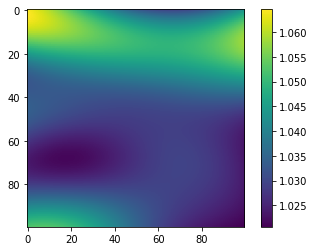

In [ ]:
uplot=np.reshape(u_pred,(100,100))
plt.imshow(uplot)
plt.colorbar()

# Plotting the actual velocity 

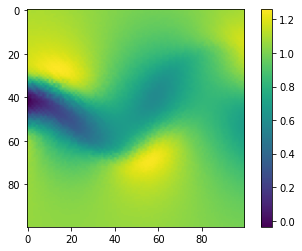

In [ ]:
upl=np.reshape(Y_star[0],(100,100))
plt.imshow(upl)
plt.colorbar()